In [1]:
!pip install -U scikit-learn
!pip install scikeras[tensorflow]
!pip install pandas
!pip install tensorflow
!pip install wfdb
!pip install -q -U tensorflow_addons
!pip install awkward
!pip install pydot

In [10]:
 os.chdir('/work/ECG_masters')
 

In [11]:
%run "tools.ipynb" 
#import tensorflow_addons as tfa

In [12]:
%run "models.ipynb" 

In [13]:
print(os.getcwd())

/work/ECG_masters


In [14]:
startdir = os.getcwd()
print(startdir)
#os.chdir(startdir)


/work/ECG_masters


In [15]:

def split_train(model, epochsN):

    #metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
    #                    columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])
    
    """change seed to 40 from 42"""
    gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
    
    for train_index, test_index in gss.split(X, y, ids):
    
        X_train = np.array(list(itemgetter(*train_index)(X)))
        X_test = np.array(list(itemgetter(*test_index)(X)))
        y_train = np.array(list(itemgetter(*train_index)(y)))
        y_test = np.array(list(itemgetter(*test_index)(y)))

        print(f"shape of x_train: {np.shape(X_train)}, type: {type(X_train)}")
        print(f"shape of x_test: {np.shape(X_test)}, type: {type(X_test)}")
        
        
        if (len(X_train)+len(X_test) != len(X)):
            raise TypeError("train and test sets don't add up!")
        
        #get time for start of training. Used in evaluate()
        start = time.time()
        
        BATCH_SIZE = 64
        #EPOCHS = 10
        INIT_LR = 1e-4
        MAX_LR = 1e-2
        
        
        #learning_rate = 0.001442874
        """
        steps_per_epoch = len(X_train) // BATCH_SIZE
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch
        )
        """
    
        #model.compile(
        #loss='binary_crossentropy',
        #optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        #optimizer= tf.keras.optimizers.SGD(clr),
        #metrics = ['accuracy'])

        history = model.fit(X_train, y_train,    
                    epochs=epochsN,
                    batch_size = 32,
                    validation_data=(X_test, y_test),
                    verbose=1)
       
        mask_tensor = model.layers[1].compute_mask(X_train)
        print(mask_tensor)



## effect of number of beats in pr beat-segmentation

/work/ECG_masters
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 12831, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 12831, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 12829, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 12829, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 6415, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 6413, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 6

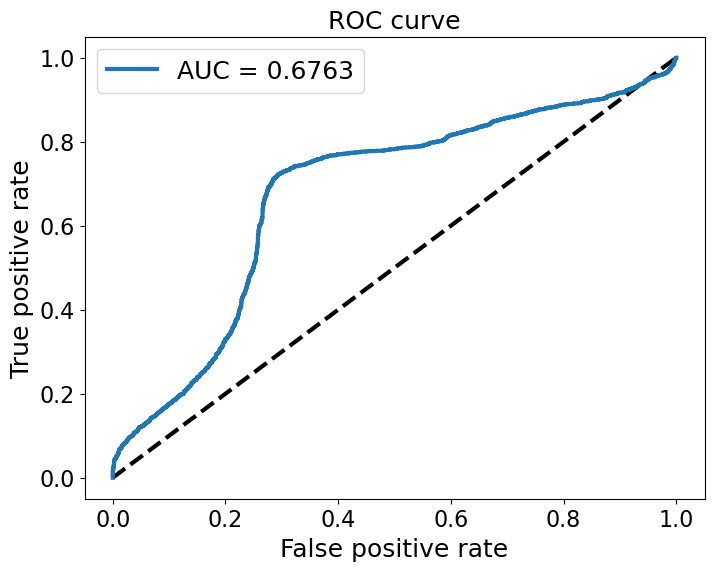

Confusion matrix, without normalization
[[2470  957]
 [ 767 1743]]


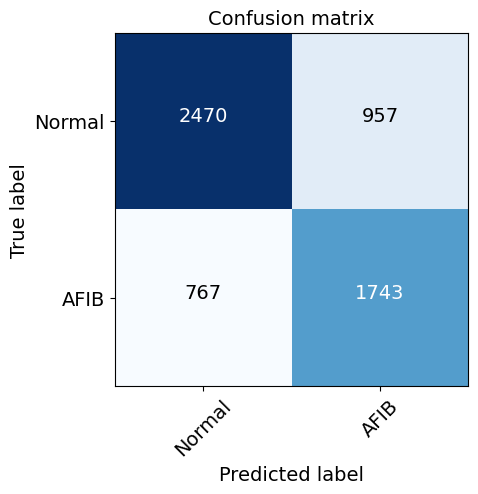

appended metrics


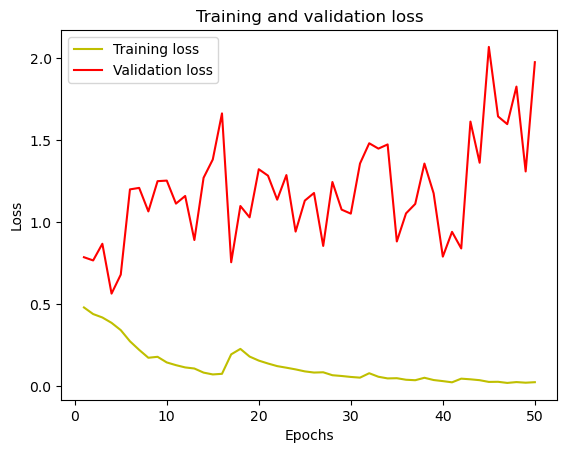

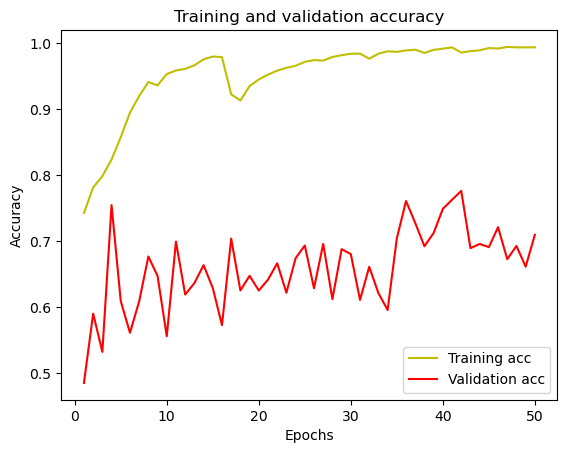

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2063, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 2063, 64)         2

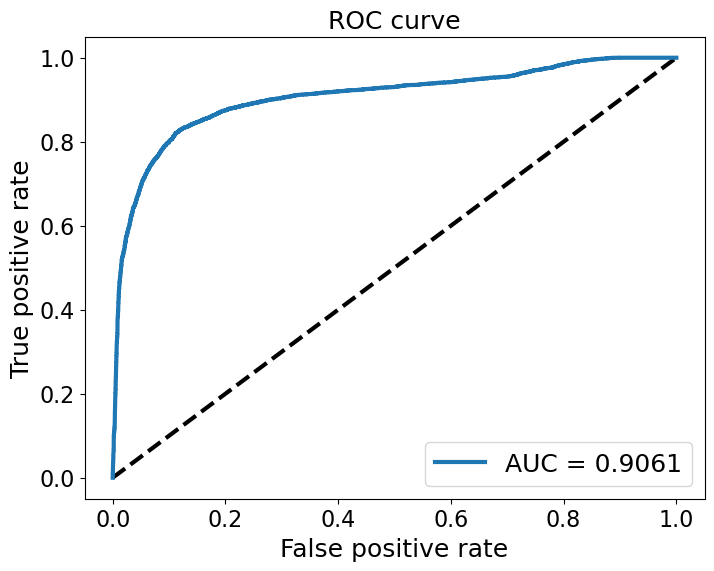

Confusion matrix, without normalization
[[9020 1275]
 [1271 6254]]


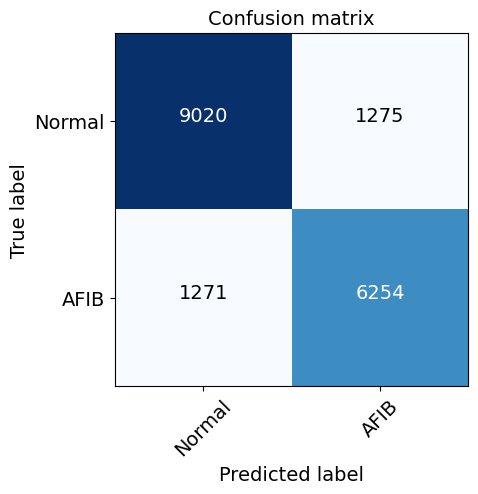

appended metrics


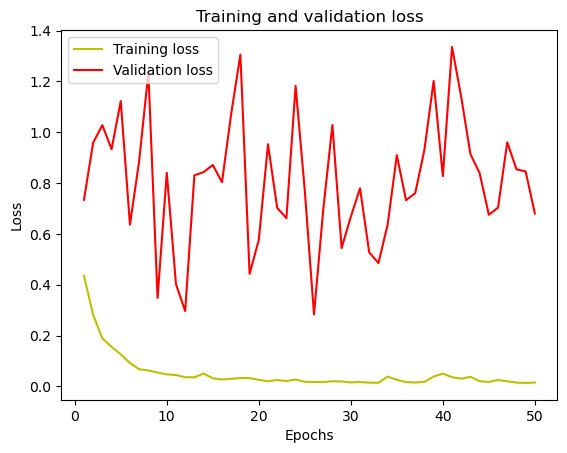

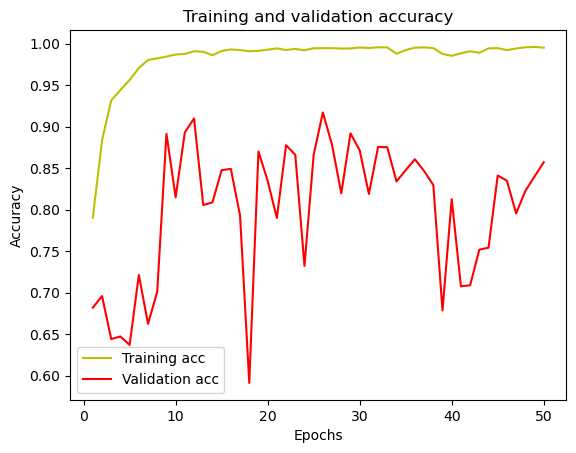

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 1955, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 1955, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 1953, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 1953, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 977, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 975, 64)           6208      
                                                                 
 batch2 (BatchNormalization)  (None, 975, 64)          2

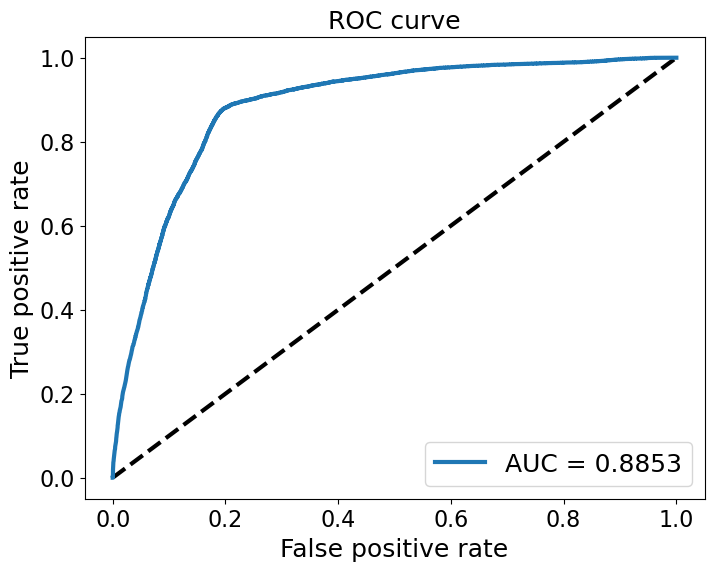

Confusion matrix, without normalization
[[16805  3794]
 [ 2108 12937]]


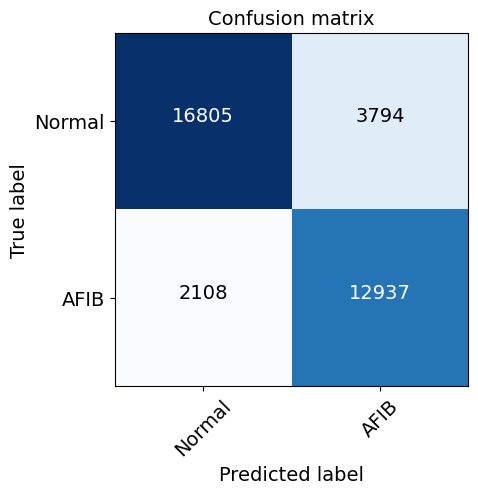

appended metrics


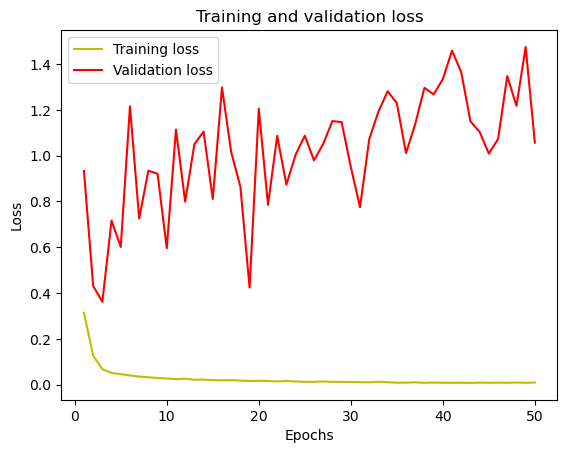

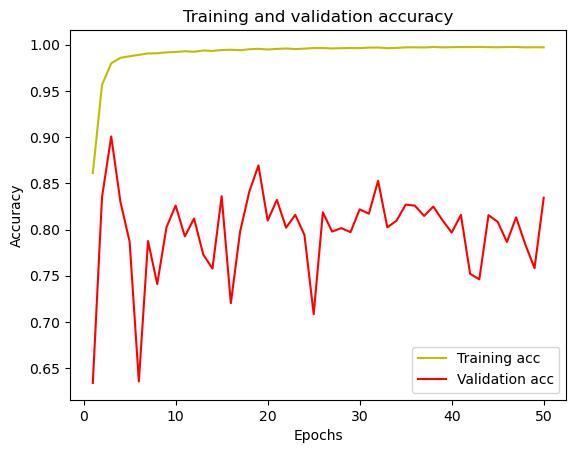

In [4]:
#import tensorflow_addons as tfa
import tensorflow as tf
import math
import awkward as ak
import numpy as np
#import pyarrow



print(os.getcwd())

datasets = [60,20,10]

for dataset in datasets:
    
    os.chdir(startdir)
    path="./data/afdb/prBt"+str(dataset)+"_trunc75/"
    #path="./data/afdb/prBt_nopad10/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    #model = buildBest_2()
    #model = build_simple_TD()
    os.chdir(startdir+'/test/prBt'+str(dataset))
    
    model = build_mask()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 50)

## investigate effect of varying truncation
for prBt20

/work/ECG_masters/data/afdb/prBt20_trunc50_overlap0
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3335, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 3335, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 3333, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 3333, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1667, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1663, 64)          10304     
                                                                 
 bat

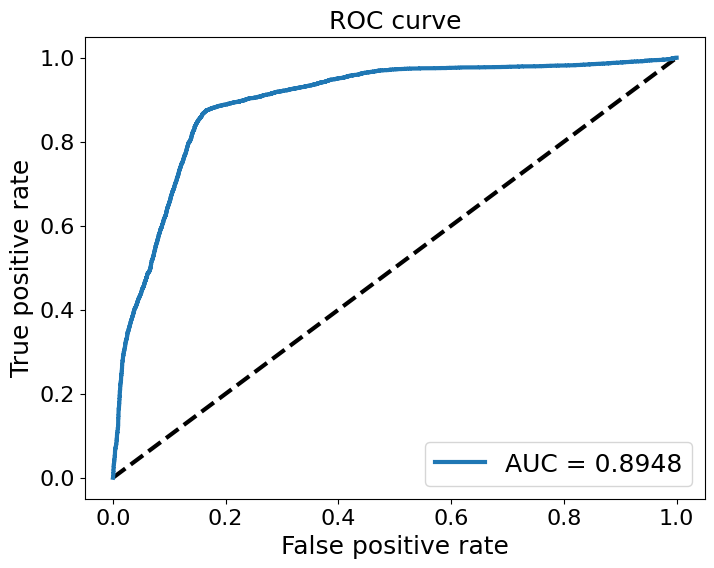

Confusion matrix, without normalization
[[5405 4890]
 [ 226 7299]]


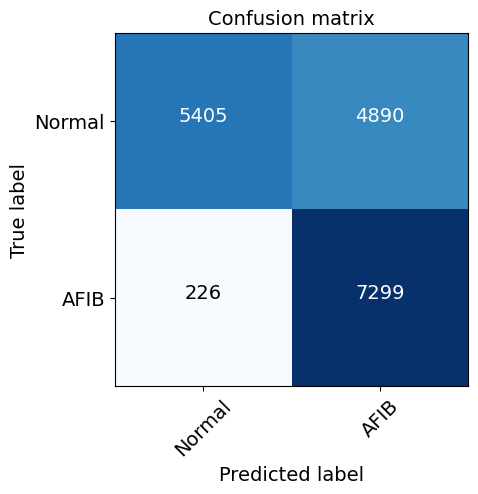

appended metrics


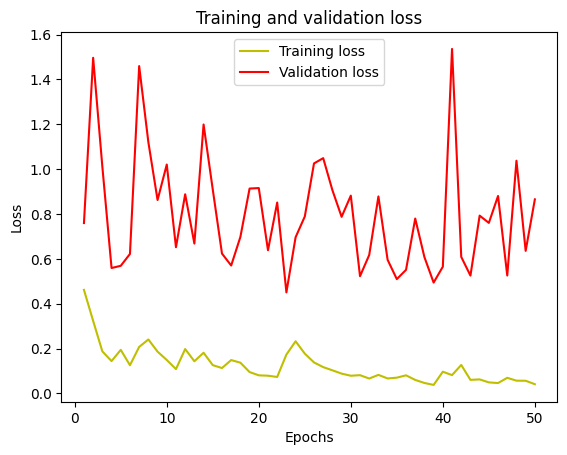

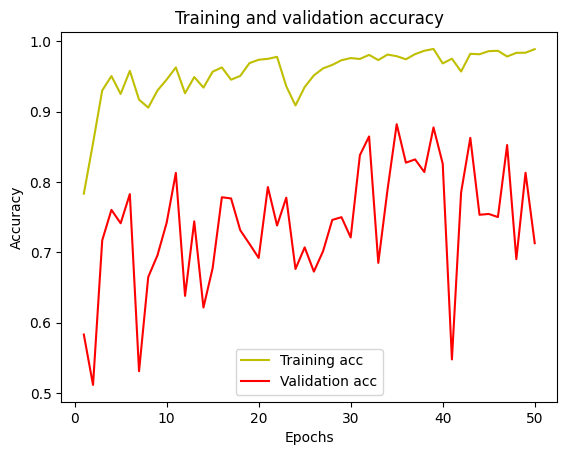

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3623, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 3623, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 3621, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 3621, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1811, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1807, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 1807, 64)         2

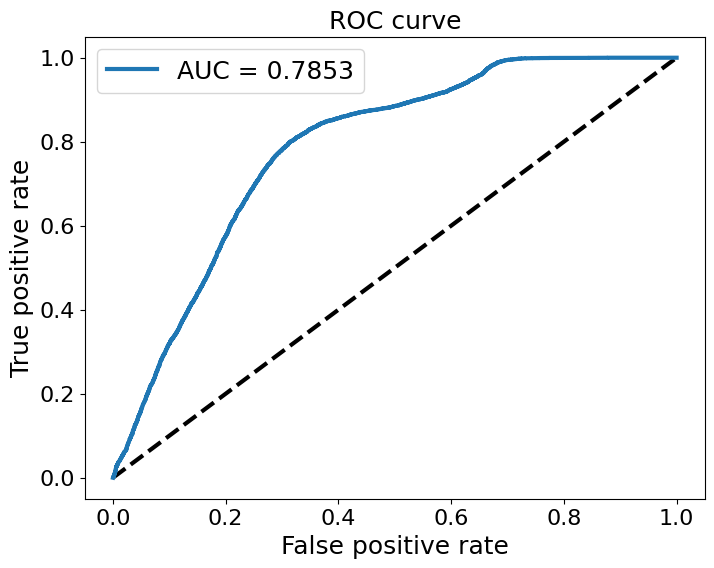

Confusion matrix, without normalization
[[5673 4622]
 [ 958 6567]]


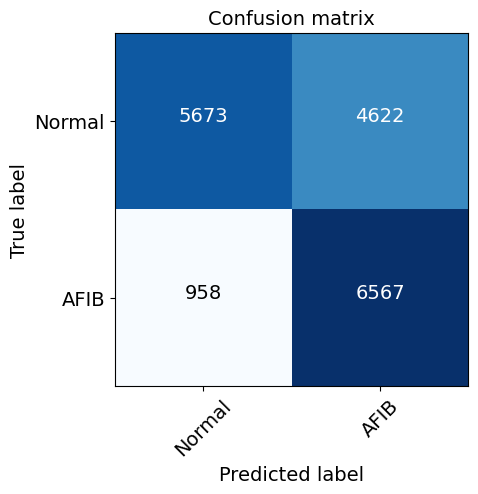

appended metrics


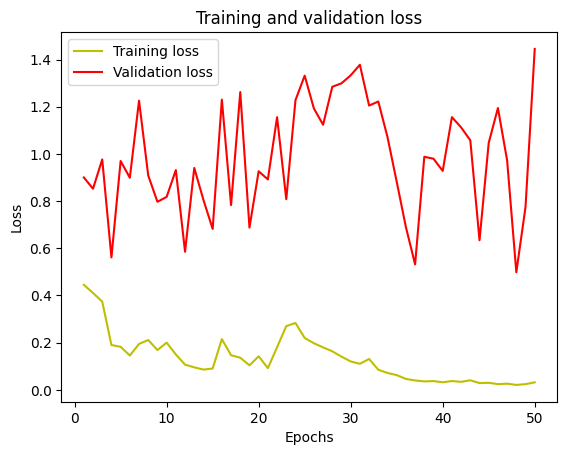

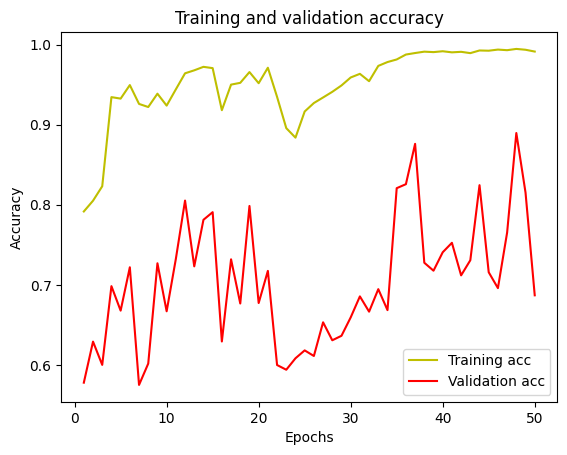

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3966, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 3966, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 3964, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 3964, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1982, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1978, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 1978, 64)         2

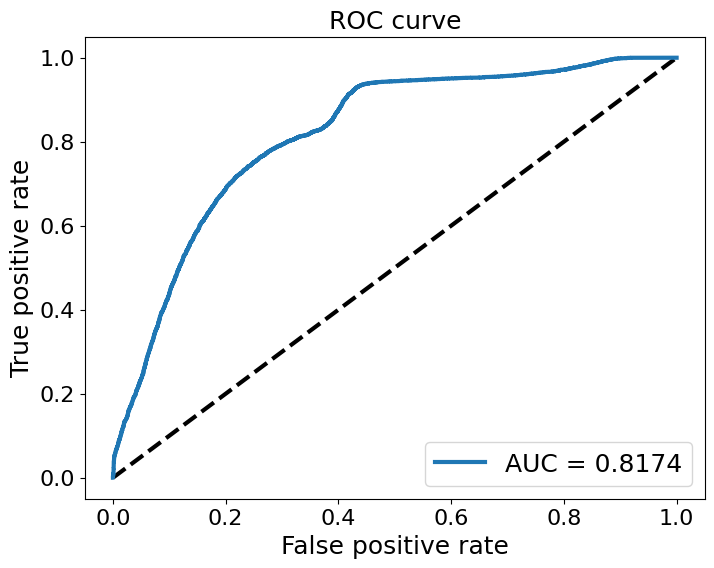

Confusion matrix, without normalization
[[5943 4352]
 [ 631 6894]]


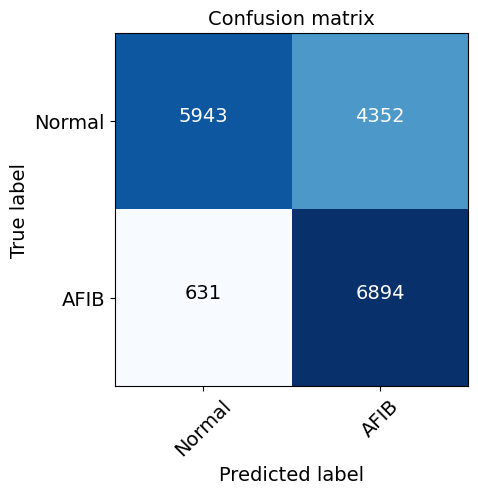

appended metrics


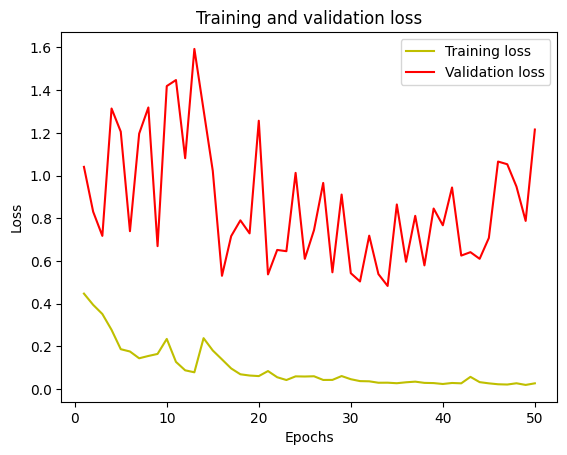

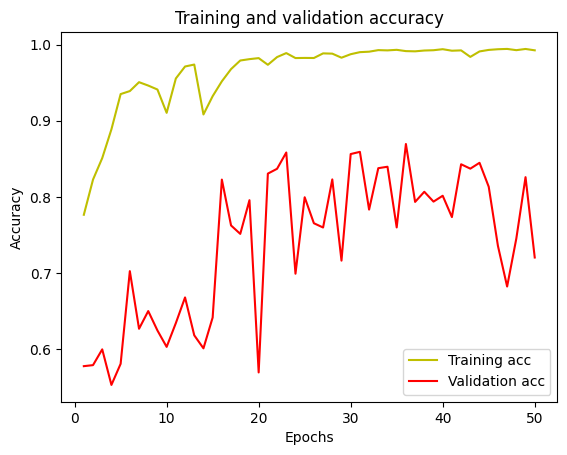

In [8]:


print(os.getcwd())

truncList = ['50_overlap0','60_overlap0','70_overlap0']

for name in truncList:
    
    os.chdir(startdir)
    path="./data/afdb/prBt20_trunc"+name+"/"
    #path="./data/afdb/prBt_nopad10/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    #model = buildBest_2()
    #model = build_simple_TD()
    os.chdir(startdir+'/data/afdb/prBt20_trunc'+name)
    
    model = build_mask_best()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 50,128)

## investigate effect of varying truncation for prBeat60 (MinMax norm pr window)

/work/ECG_masters
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 10341, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 10341, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 10339, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 10339, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5170, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5166, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5

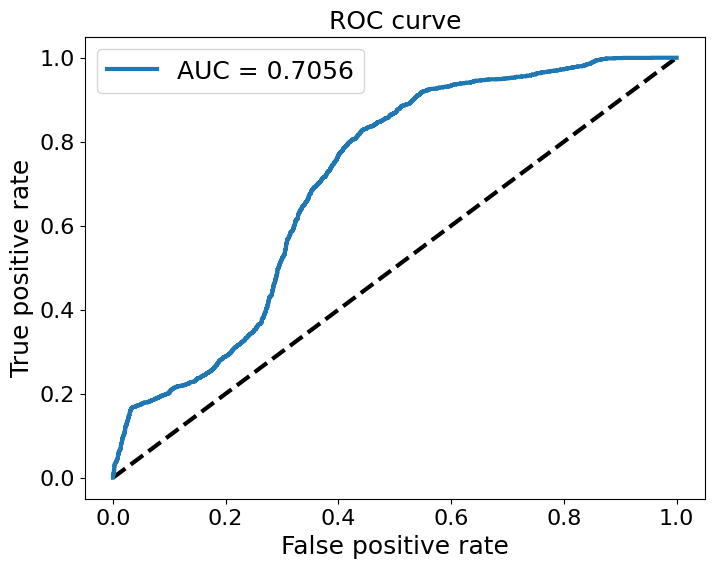

Confusion matrix, without normalization
[[2073 1354]
 [ 619 1891]]


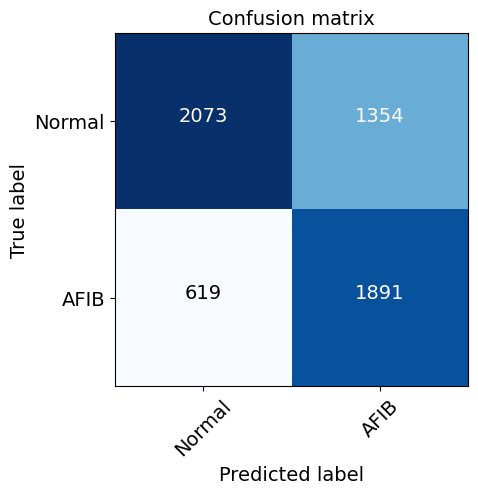

appended metrics


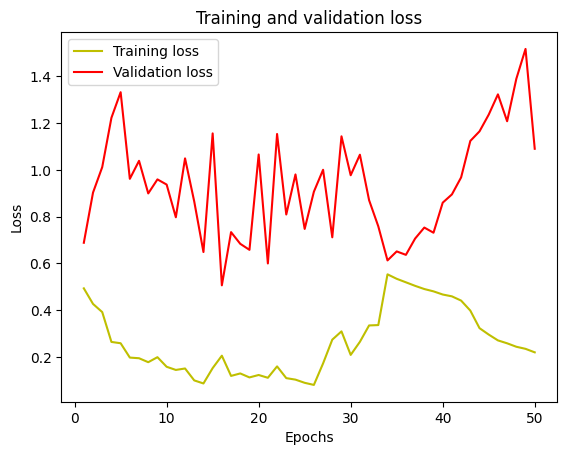

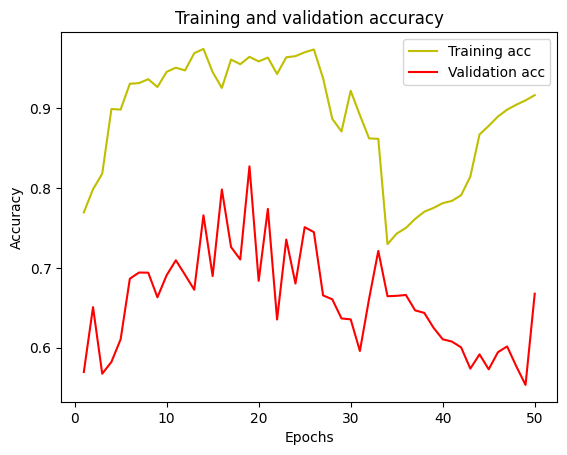

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         2

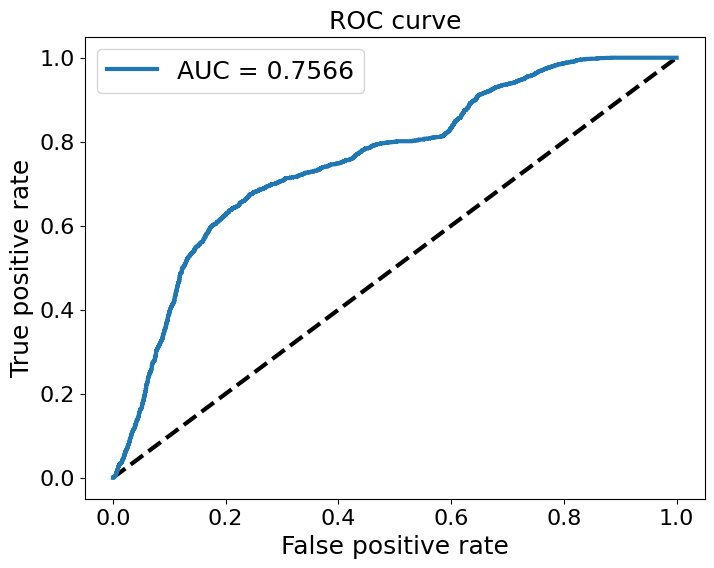

Confusion matrix, without normalization
[[1980 1447]
 [ 604 1906]]


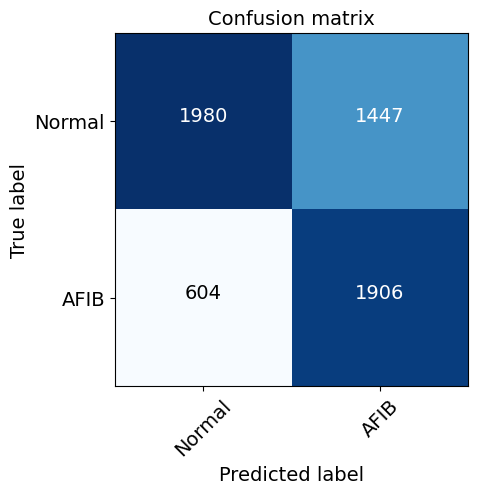

appended metrics


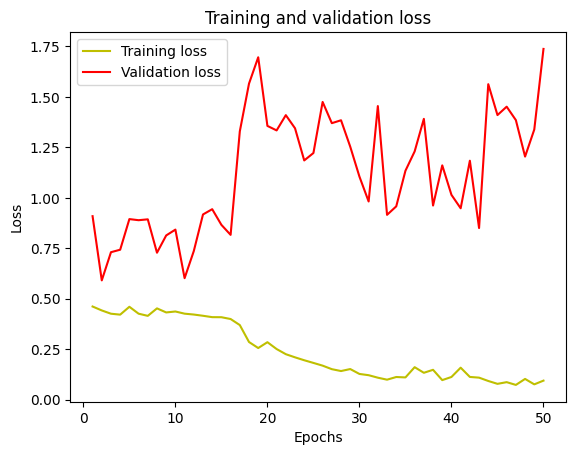

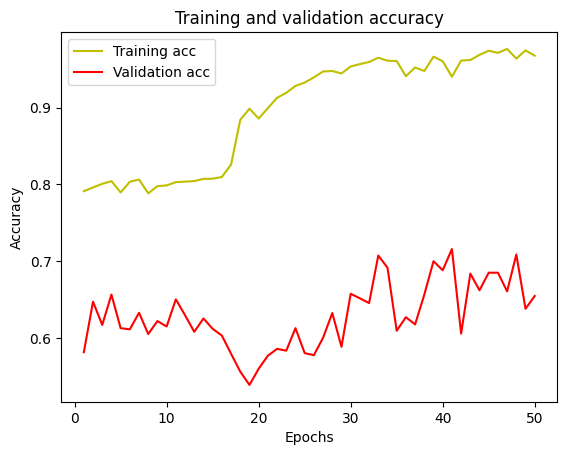

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 12307, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 12307, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 12305, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 12305, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 6153, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 6149, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 6149, 64)         2

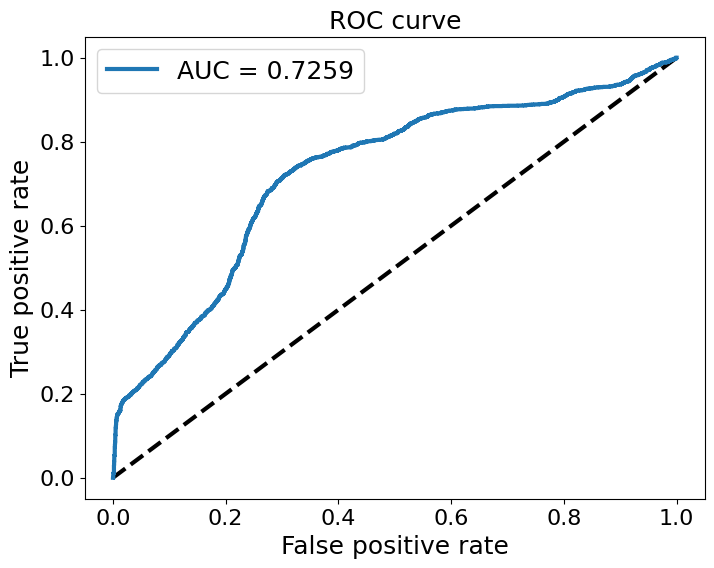

Confusion matrix, without normalization
[[1858 1569]
 [ 497 2013]]


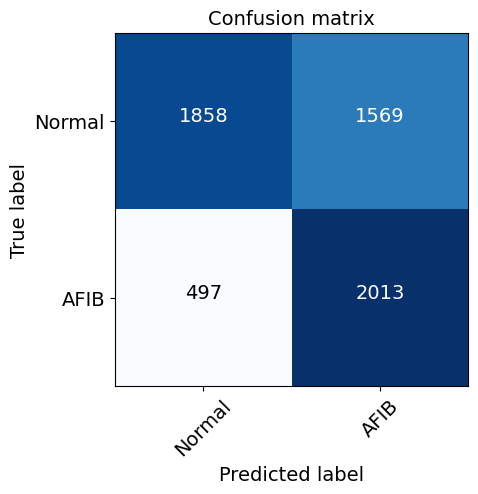

appended metrics


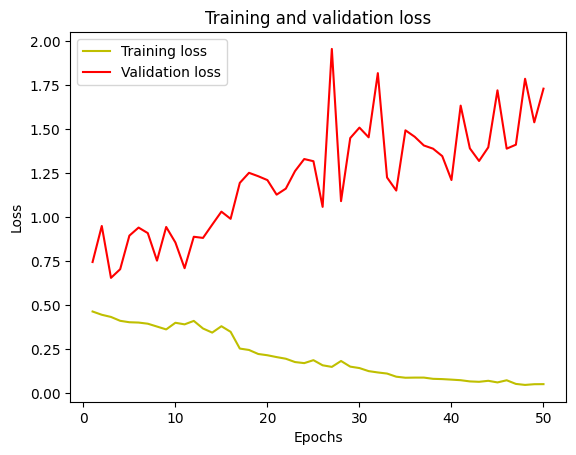

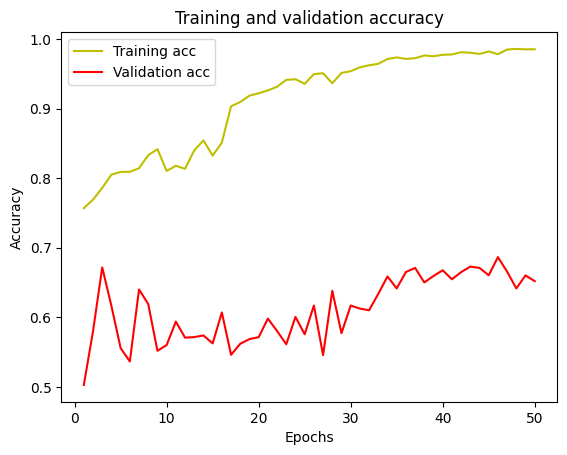

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 12831, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 12831, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 12829, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 12829, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 6415, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 6411, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 6411, 64)         2

KeyboardInterrupt: 

In [32]:


print(os.getcwd())

truncList = ['50_overlap0','60_overlap0','70_overlap0', '75']

for name in truncList:
    
    os.chdir(startdir)
    path="./data/afdb/prBt60_trunc"+name+"/"
    #path="./data/afdb/prBt_nopad10/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    #model = buildBest_2()
    #model = build_simple_TD()
    os.chdir(startdir+'/data/afdb/prBt60_trunc'+name)
    
    model = build_mask_best()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 50)

## investigate effect of varying scaling method pr ID on robustness 
- maybe check on logo to make sure.

/work/ECG_masters/data/afdb/prBt20_trunc75_MinMax
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2061, 64)          10304     
                                                                 
 batch

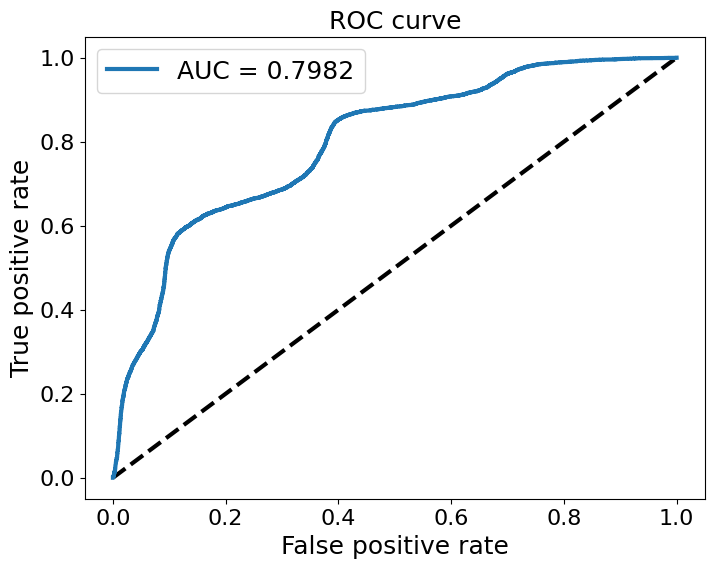

Confusion matrix, without normalization
[[8790 1505]
 [2928 4597]]


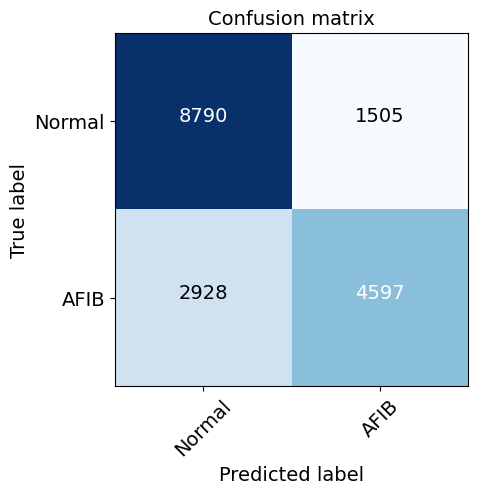

appended metrics


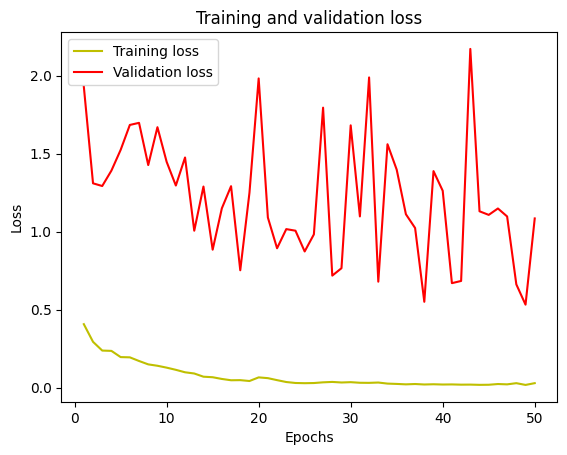

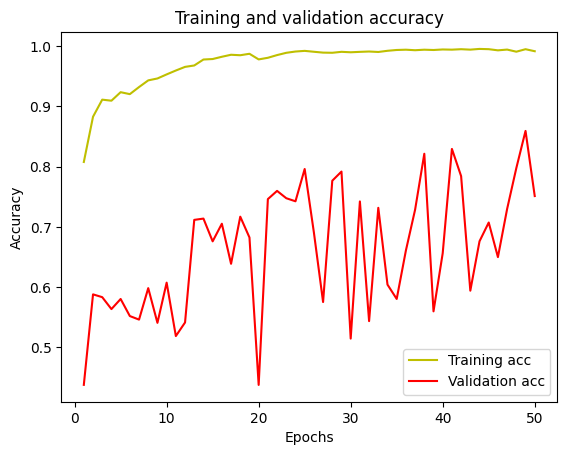

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2061, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 2061, 64)         2

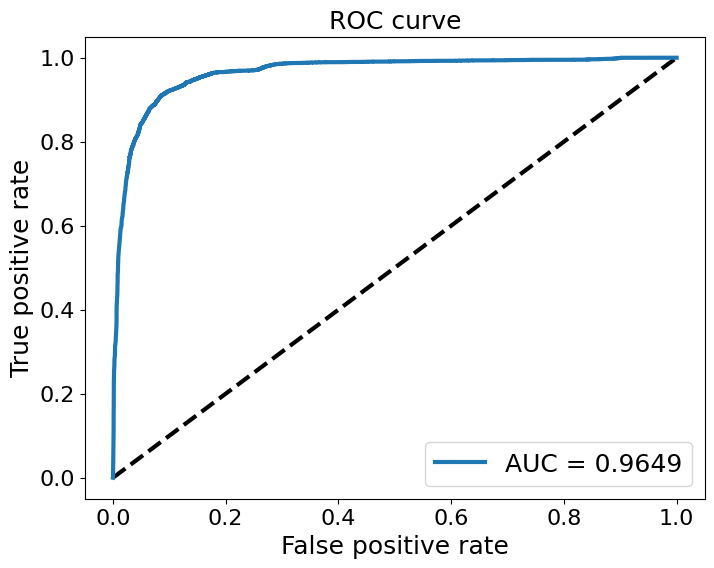

Confusion matrix, without normalization
[[9379  916]
 [ 658 6867]]


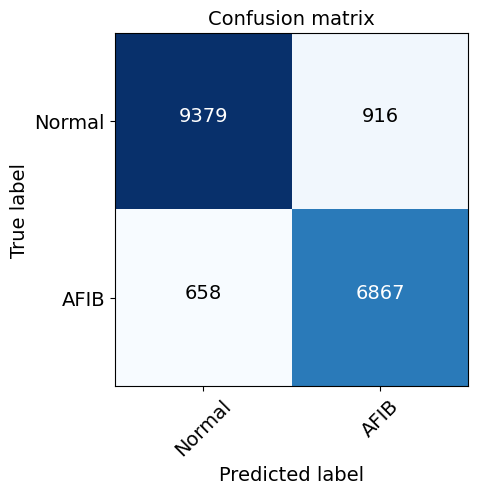

appended metrics


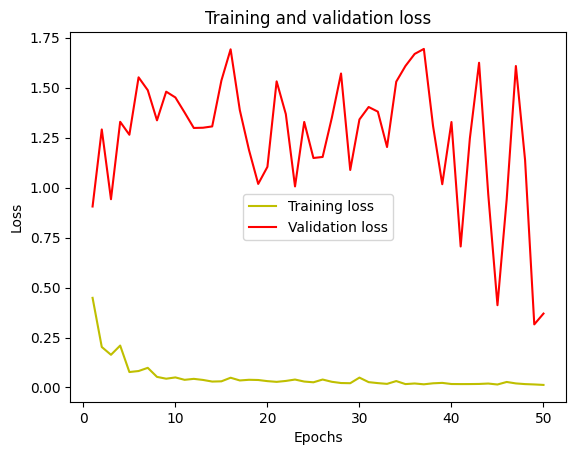

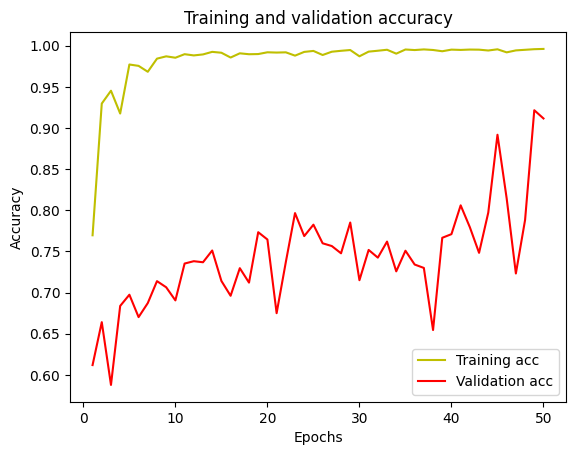

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2061, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 2061, 64)         2

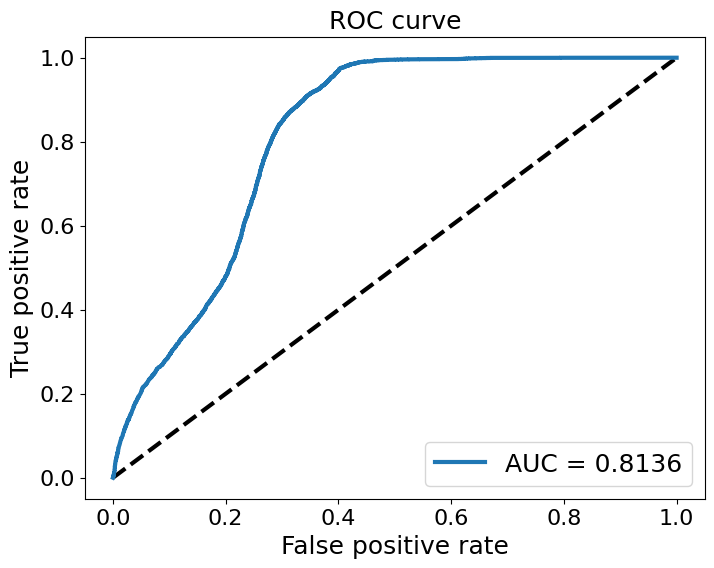

Confusion matrix, without normalization
[[6288 4007]
 [ 328 7197]]


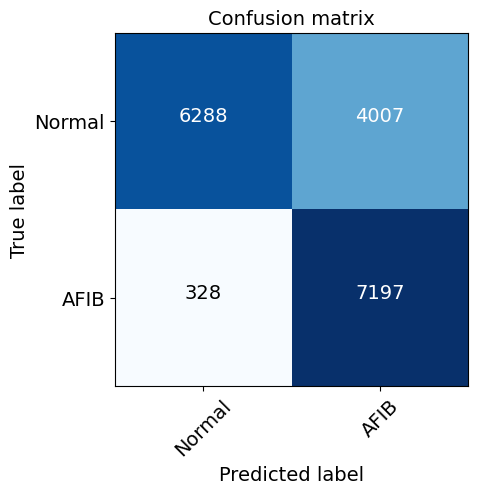

appended metrics


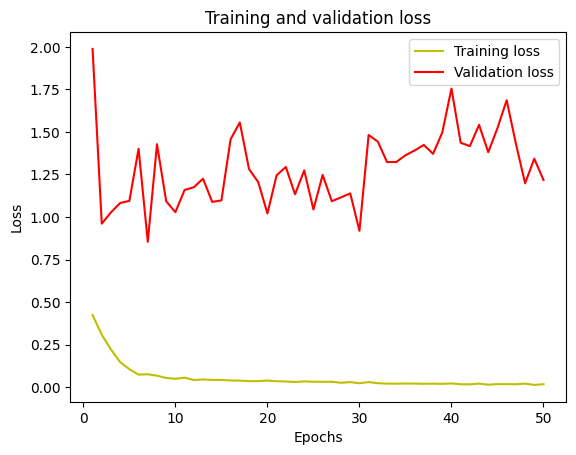

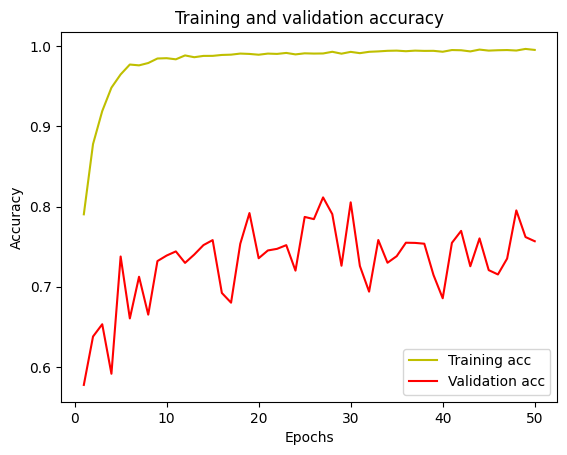

In [17]:
print(os.getcwd())

scaleList = ['MinMax','Robust','Standard']

for mode in scaleList:
    
    os.chdir(startdir)
    
    path='./data/afdb/prBt20_trunc75_'+mode+"/"
    #path="./data/afdb/prBt_nopad10/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    #model = buildBest_2()
    #model = build_simple_TD()
    os.chdir(startdir+'/data/afdb/prBt20_trunc75_'+mode)
    
    model = build_mask_best()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 50,128)

## investigate effect of varying global scaling method on robustness for prBt20

/work/ECG_masters
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2061, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 2

2023-04-21 09:06:38.084656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-21 09:06:38.317832: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbfb4521210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-21 09:06:38.317860: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-04-21 09:06:38.326077: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-21 09:06:38.495906: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


302/302 [==============================] - 21s 56ms/step - loss: 0.5072 - accuracy: 0.7406 - val_loss: 0.9537 - val_accuracy: 0.4224
Epoch 2/50
302/302 [==============================] - 16s 54ms/step - loss: 0.4742 - accuracy: 0.7653 - val_loss: 0.7048 - val_accuracy: 0.5708
Epoch 3/50
302/302 [==============================] - 16s 53ms/step - loss: 0.4419 - accuracy: 0.7877 - val_loss: 0.8290 - val_accuracy: 0.6064
Epoch 4/50
302/302 [==============================] - 16s 53ms/step - loss: 0.4204 - accuracy: 0.7989 - val_loss: 0.8703 - val_accuracy: 0.6125
Epoch 5/50
302/302 [==============================] - 16s 53ms/step - loss: 0.4190 - accuracy: 0.8002 - val_loss: 0.8707 - val_accuracy: 0.6597
Epoch 6/50
302/302 [==============================] - 16s 54ms/step - loss: 0.4172 - accuracy: 0.8004 - val_loss: 0.9083 - val_accuracy: 0.6339
Epoch 7/50
302/302 [==============================] - 16s 52ms/step - loss: 0.4076 - accuracy: 0.8061 - val_loss: 0.8266 - val_accuracy: 0.6261
Epo

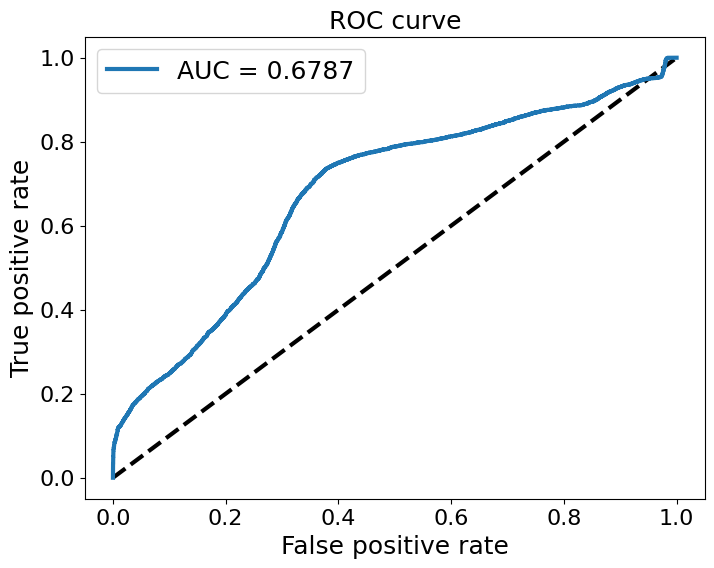

Confusion matrix, without normalization
[[4134 6161]
 [1411 6114]]


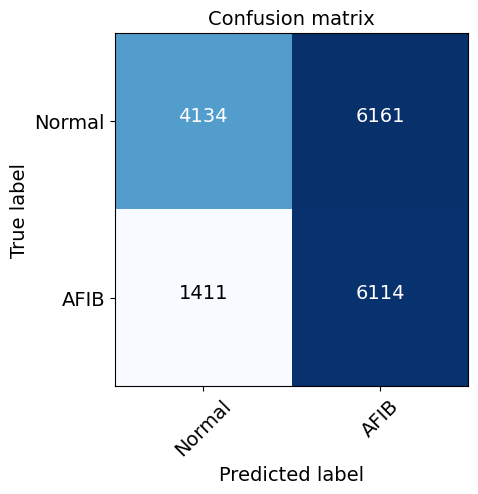

appended metrics


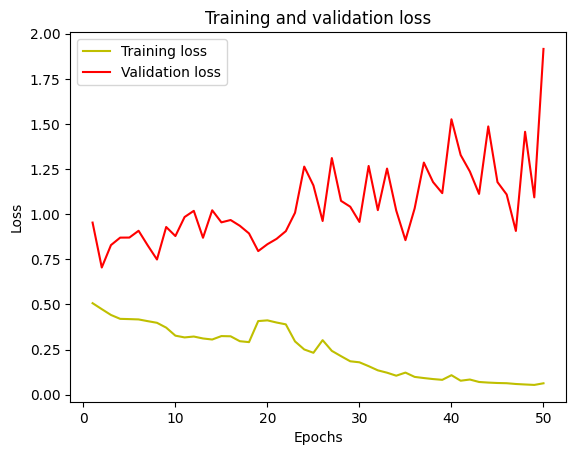

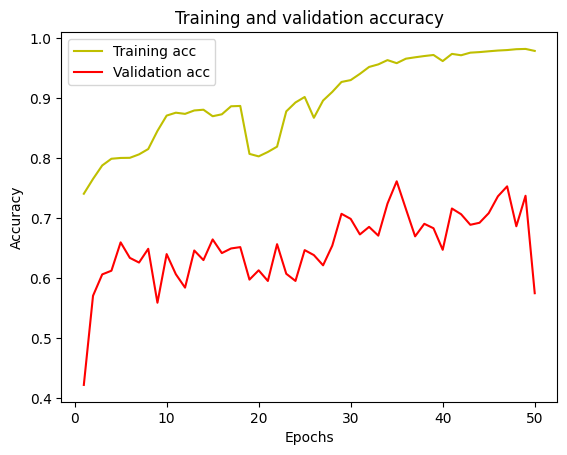

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2061, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 2061, 64)         2

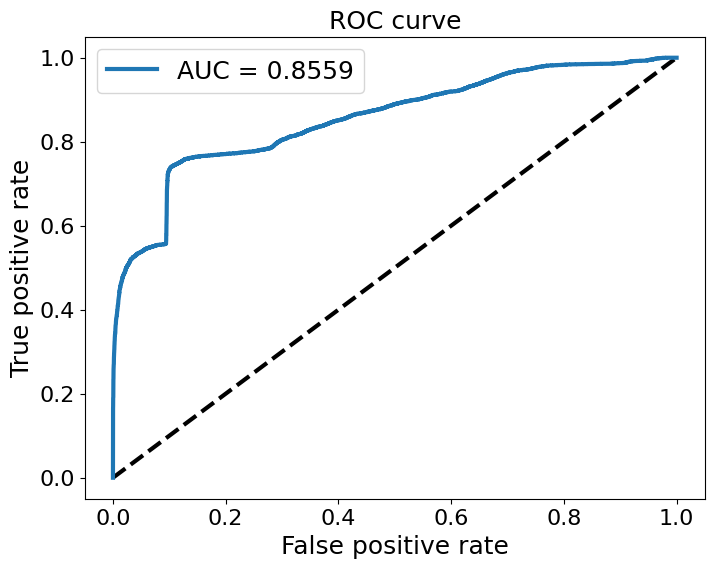

Confusion matrix, without normalization
[[6222 4073]
 [1132 6393]]


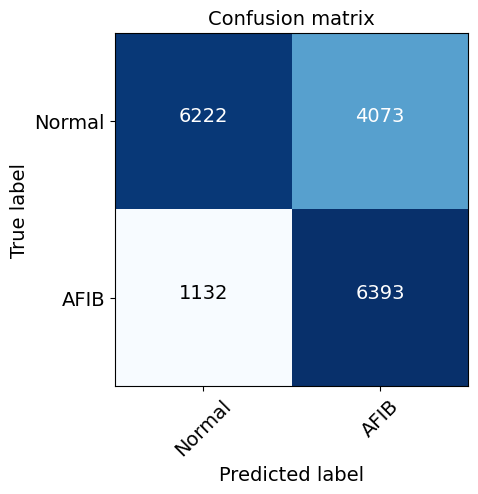

appended metrics


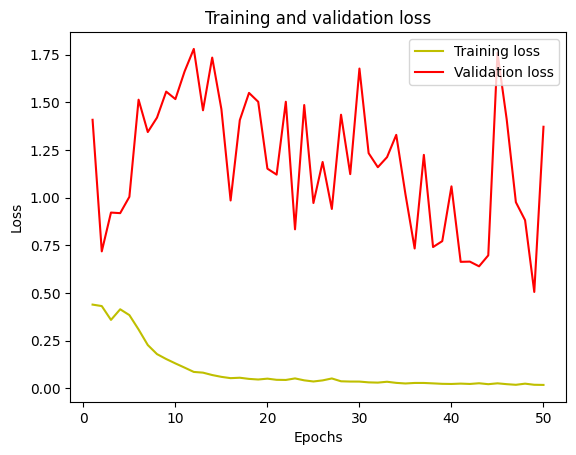

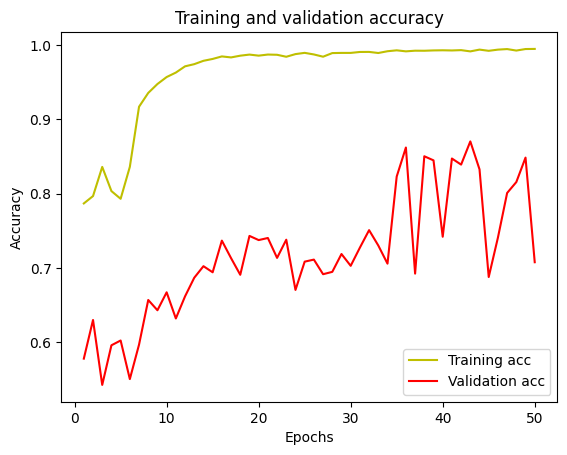

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2061, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 2061, 64)         2

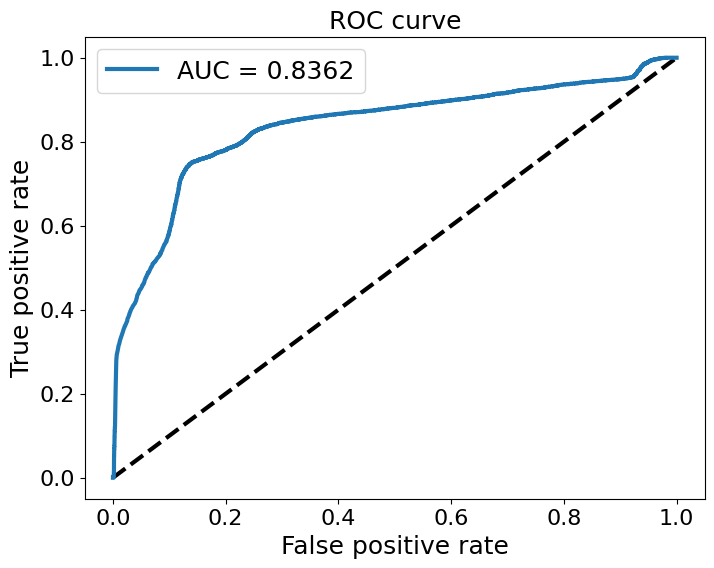

Confusion matrix, without normalization
[[7498 2797]
 [1235 6290]]


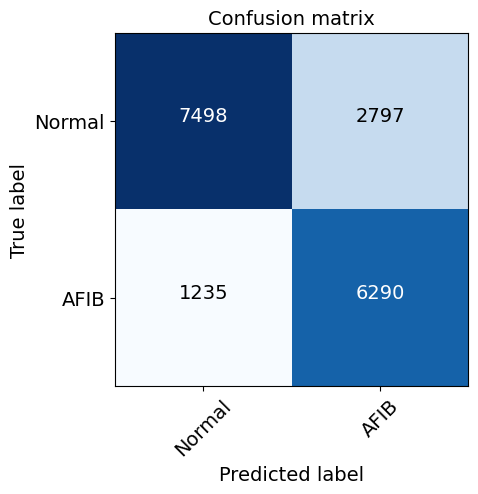

appended metrics


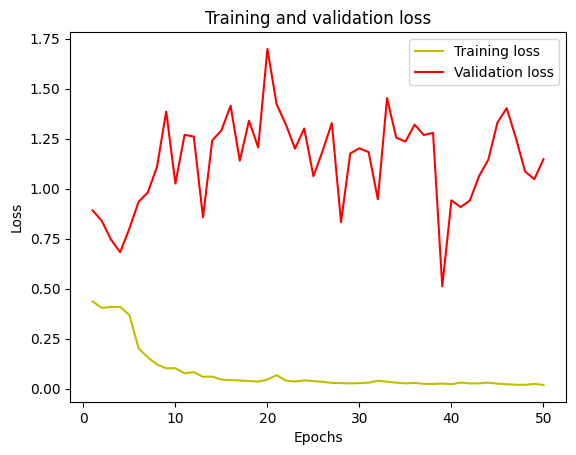

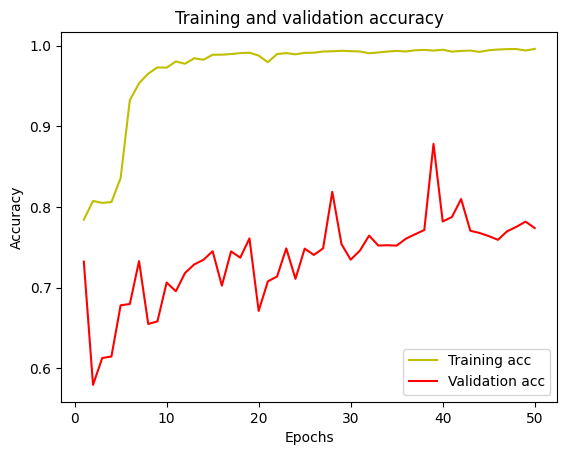

In [22]:

print(os.getcwd())

scaleList = [[MinMaxScaler,'MinMax'],[RobustScaler,'Robust'],[StandardScaler,'Standard']]

for mode in scaleList:
    
    os.chdir(startdir)
    
    path='./data/afdb/prBt20_trunc75_noScale/'
   
    X = np.load(path+"X.npy",allow_pickle=True)
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)
    
    os.chdir(startdir+'/results/prBt20Global_'+mode[1])   
    
    model = build_mask_best()
    
    split_train_scale_eval(model, 50, mode[0], 128)

## investigate effect of varying global scaling method on robustness for prBt60

/work/ECG_masters/results/prBt20Global_Standard
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 

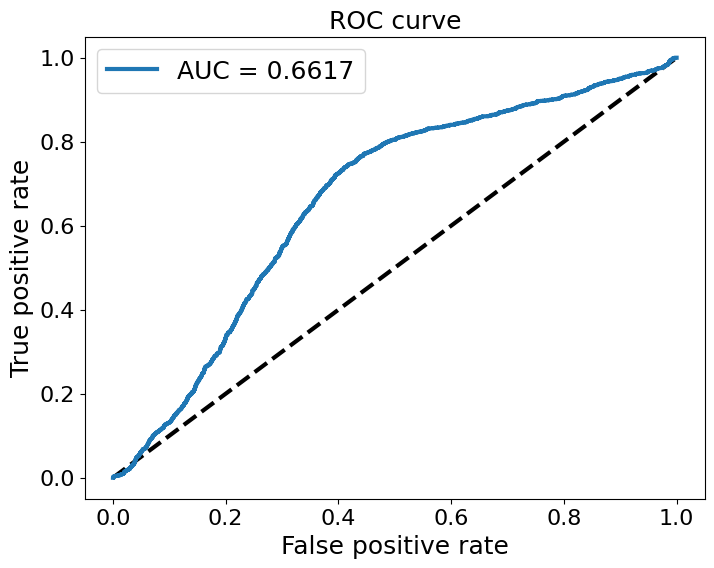

Confusion matrix, without normalization
[[1818 1609]
 [ 539 1971]]


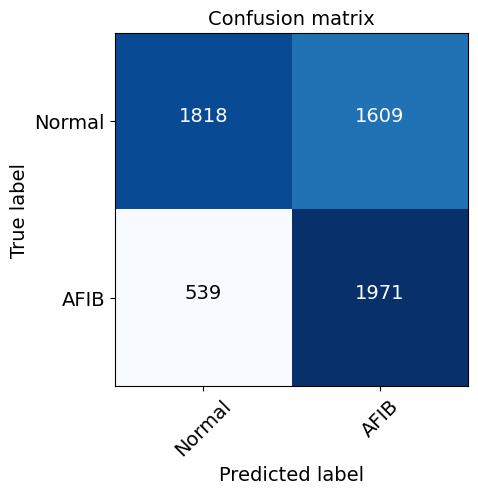

appended metrics


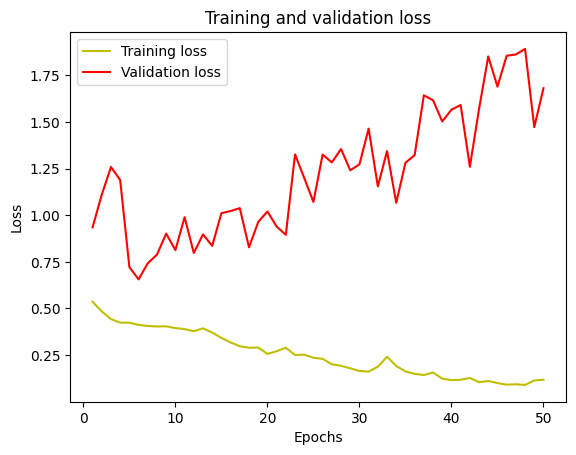

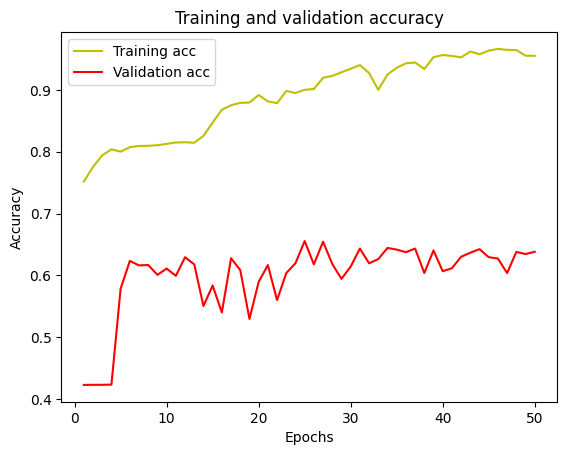

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         2

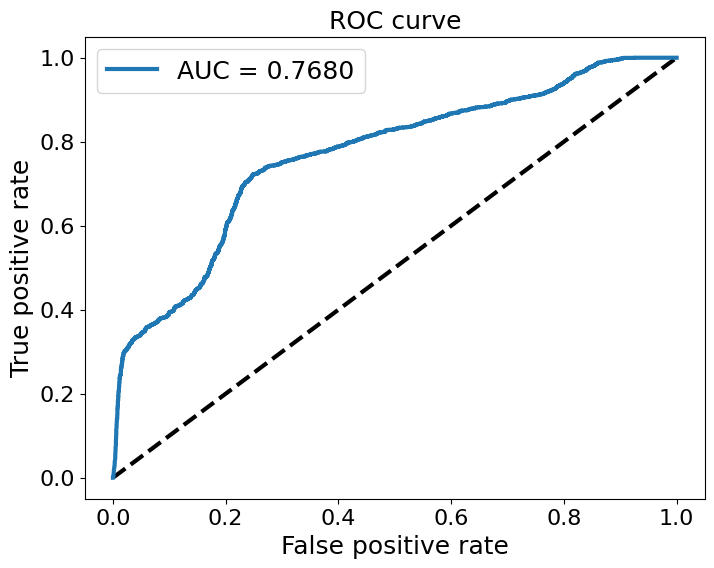

Confusion matrix, without normalization
[[2307 1120]
 [ 601 1909]]


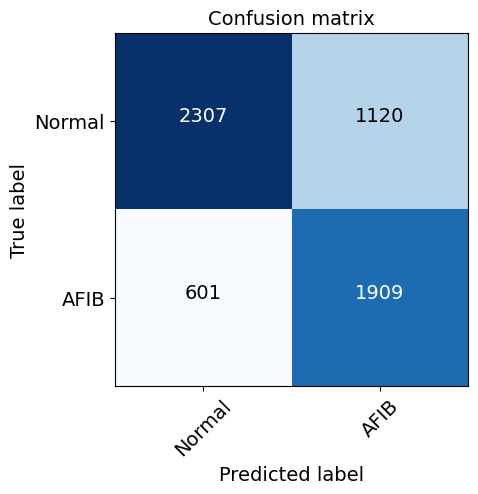

appended metrics


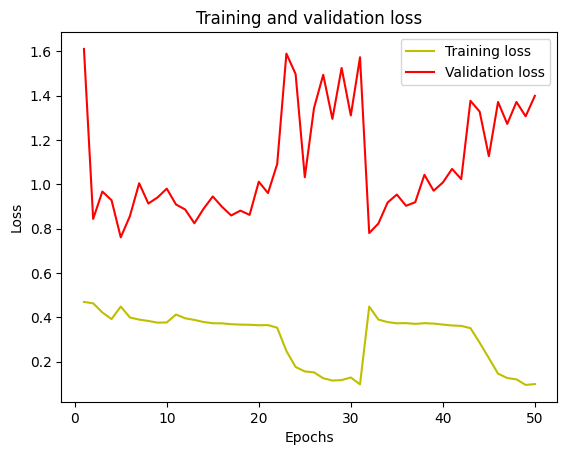

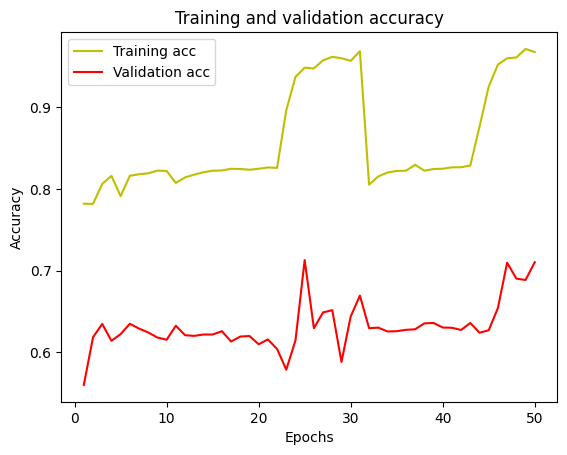

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         2

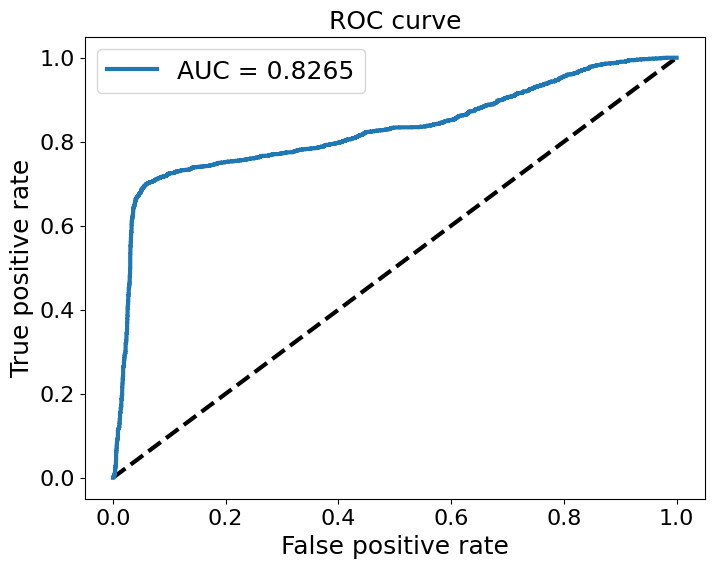

Confusion matrix, without normalization
[[2876  551]
 [ 648 1862]]


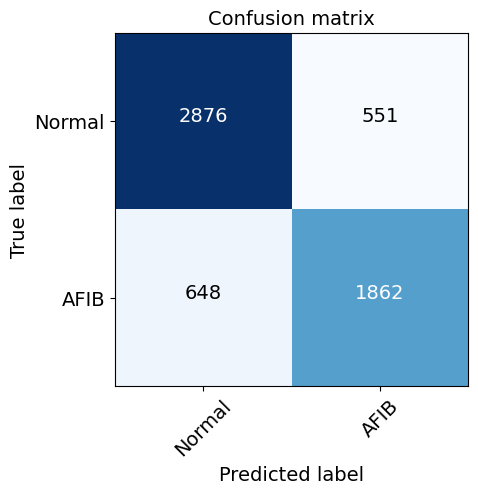

appended metrics


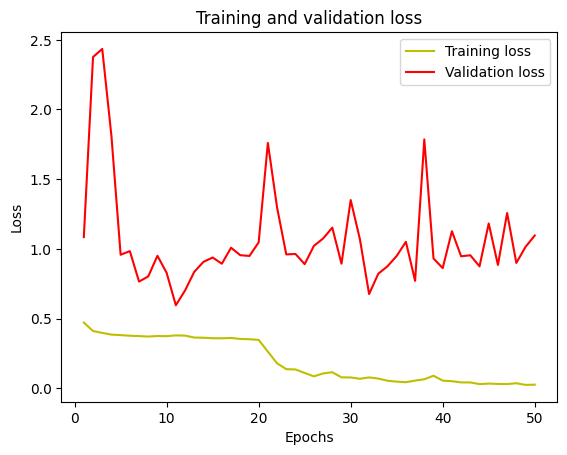

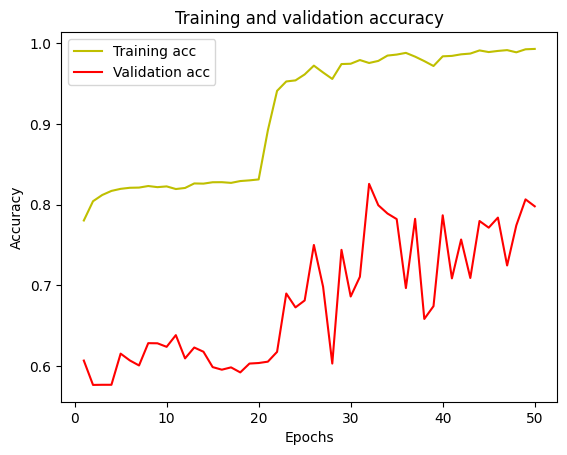

In [23]:

print(os.getcwd())

scaleList = [[MinMaxScaler,'MinMax'],[RobustScaler,'Robust'],[StandardScaler,'Standard']]

for mode in scaleList:
    
    os.chdir(startdir)
    
    path='./data/afdb/prBt60_trunc60_noScale/'
   
    X = np.load(path+"X.npy",allow_pickle=True)
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)
    
    os.chdir(startdir+'/results/prBt60Global_'+mode[1])   
    
    model = build_mask_best()
    
    split_train_scale_eval(model, 50, mode[0], 128)

## compare w/ or w/o normalisation. Would be idea to include standardization since a number of papers does this as well


/work/ECG_masters
Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 2998, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 2998, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1499, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1497, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 1497, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 749, 64

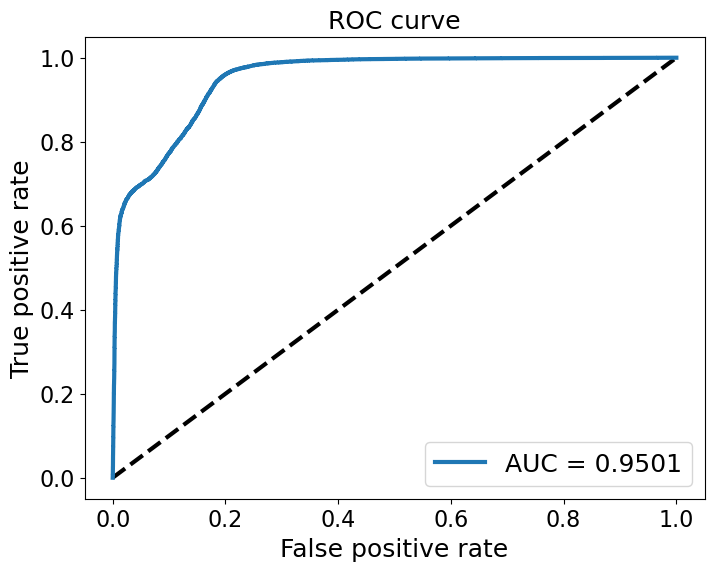

Confusion matrix, without normalization
[[19829  3917]
 [ 1546 14126]]


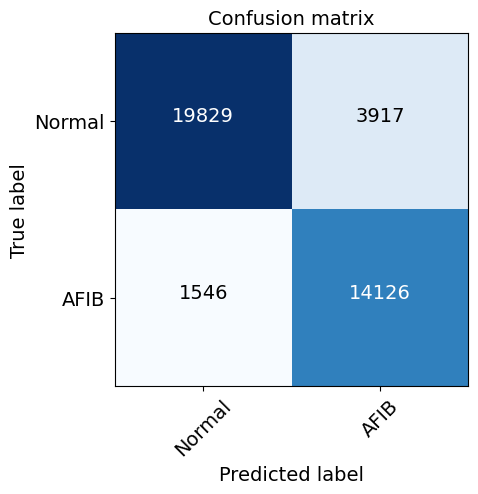

appended metrics


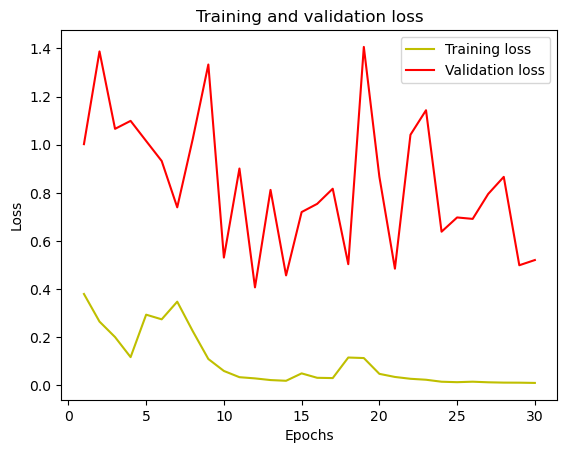

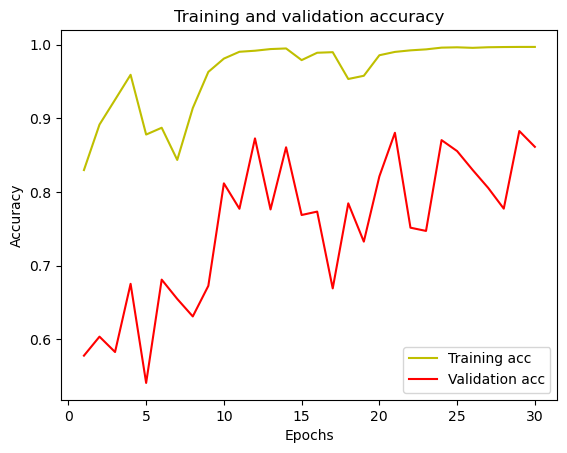

Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 2998, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 2998, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1499, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1497, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 1497, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 749, 64)           0     

In [ ]:



print(os.getcwd())

#"noNorm_ol5_win12"
#winNorm_ol5_win12
datasets = ["winNorm_ol5_win12/", "noNorm_ol5_win12/"]

for dataset in datasets:
    
    os.chdir(startdir)
    path="./data/afdb/"+dataset    
    #path="./data/afdb/prBt_nopad10/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

   
    #model = build_simple_TD()
    os.chdir(startdir+'/results/'+dataset)
    
    model = buildBest_2()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 30)

In [ ]:
print(os.getcwd())

#"noNorm_ol5_win12"
#winNorm_ol5_win12
datasets = [ "noNorm_ol5_win12/"]

for dataset in datasets:
    
    os.chdir(startdir)
    path="./data/afdb/"+dataset    
    #path="./data/afdb/prBt_nopad10/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

   
    #model = build_simple_TD()
    os.chdir(startdir+'/results/'+dataset)
    
    model = buildBest_2()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 30)

/work/ECG_masters
Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 2998, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 2998, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1499, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1497, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 1497, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 749, 64

## investigate effect of larger model using pr number beats data (minMAxnormalized pr window)

/work/ECG_masters
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 conv1a (Conv1D)             (None, 4129, 32)          128       
                                                                 
 conv1b (Conv1D)             (None, 4127, 32)          3104      
                                                                 
 batch1 (BatchNormalization)  (None, 4127, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2064, 32)          0         
                                                                 
 dropout_3 (Dropout)         (None, 2064, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 20

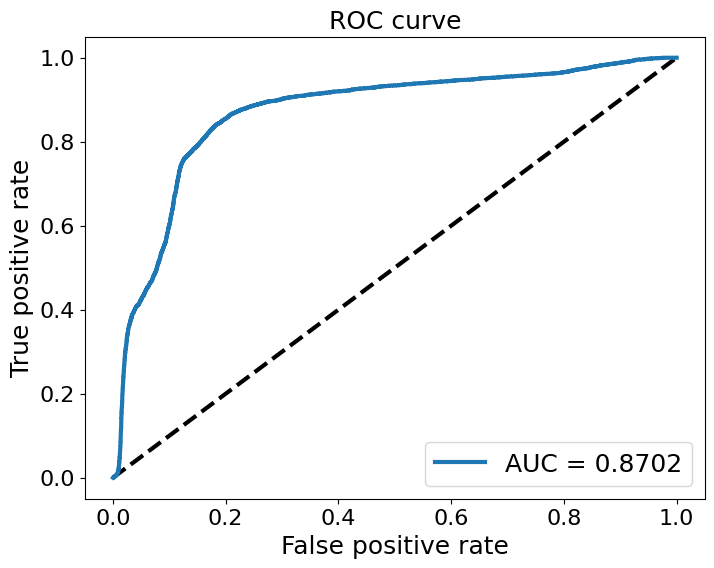

Confusion matrix, without normalization
[[8624 1671]
 [1433 6092]]


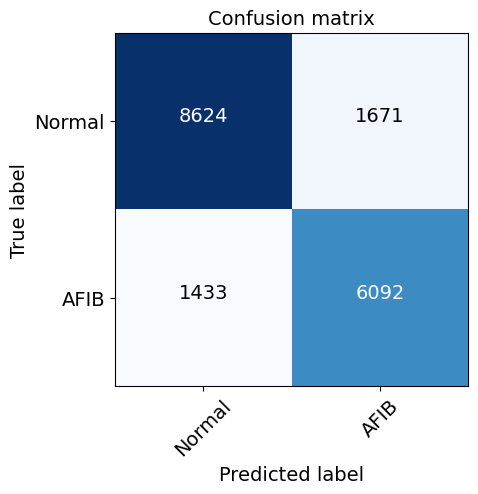

appended metrics


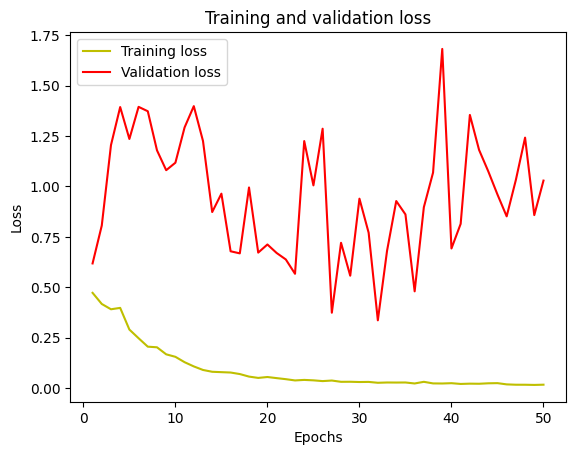

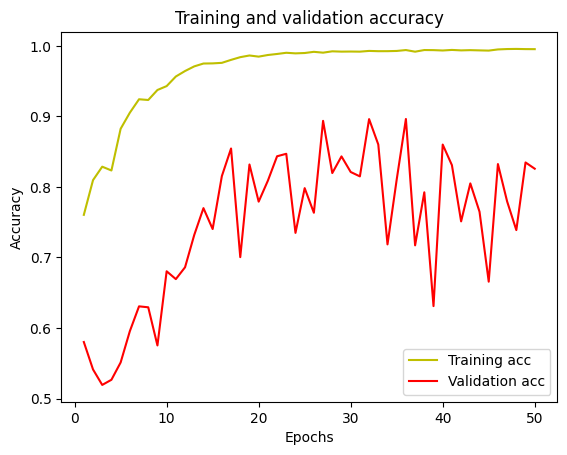

In [14]:


print(os.getcwd())

    
os.chdir(startdir)
path="./data/afdb/prBt20_trunc75/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

os.chdir(startdir+'/results/170401')

model = build_moreLSTM_mask()

#history = model.fit(x_train, y_train, epochs=3)
#mask_tensor = model.layers[1].compute_mask(x_train)

split_train_eval(model, 50, 128)

## investigate effect of varying fixed lenght w MinMax pr segment

In [6]:
datasets = [2,4,6,8,10,12,16,20,30,40]

for dataset in datasets:
    
    os.chdir(startdir)
    path="./data/afdb/MinMax_ol0_win"+str(dataset)+"/"
    X = np.load(path+"X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load(path+"y.npy",allow_pickle=True)
    ids = np.load(path+"ids.npy",allow_pickle=True)

    #reshape data: 
    # reshape input to be [samples, time steps, features = 1]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))


    os.chdir("./data/afdb/MinMax_ol0_win"+str(dataset))
             
    model =  buildBest_2()

    #history = model.fit(x_train, y_train, epochs=3)
    #mask_tensor = model.layers[1].compute_mask(x_train)

    split_train_eval(model, 50,32)

Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 500, 1)]          0         
                                                                 
 conv1 (Conv1D)              (None, 498, 32)           128       
                                                                 
 batch1 (BatchNormalization)  (None, 498, 32)          128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 249, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 247, 64)           6208      
                                                                 
 batch2 (BatchNormalization)  (None, 247, 64)          256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 124, 64)           0     

KeyboardInterrupt: 

## investigate effect of using RobustScaler pr ID w/ fixed length

/work/ECG_masters


2023-04-18 11:07:41.577885: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 11:07:41.747104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
2023-04-18 11:07:41.748337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 2998, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 2998, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1499, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1497, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 1497, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 749, 64)           0     

2023-04-18 11:07:47.153202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-18 11:07:47.371538: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efab52e41d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-18 11:07:47.371560: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-04-18 11:07:47.371566: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-04-18 11:07:47.377592: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-18 11:07:47.519027: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2770/2770 [==============================] - 118s 41ms/step - loss: 0.2730 - accuracy: 0.8864 - val_loss: 1.2853 - val_accuracy: 0.6946
Epoch 2/50
2770/2770 [==============================] - 114s 41ms/step - loss: 0.2411 - accuracy: 0.9030 - val_loss: 1.7097 - val_accuracy: 0.5780
Epoch 3/50
2770/2770 [==============================] - 112s 40ms/step - loss: 0.0745 - accuracy: 0.9764 - val_loss: 1.4542 - val_accuracy: 0.7302
Epoch 4/50
2770/2770 [==============================] - 114s 41ms/step - loss: 0.0440 - accuracy: 0.9881 - val_loss: 1.3459 - val_accuracy: 0.7460
Epoch 5/50
2770/2770 [==============================] - 113s 41ms/step - loss: 0.0293 - accuracy: 0.9930 - val_loss: 1.3781 - val_accuracy: 0.7620
Epoch 6/50
2770/2770 [==============================] - 112s 40ms/step - loss: 0.0220 - accuracy: 0.9948 - val_loss: 0.6570 - val_accuracy: 0.8267
Epoch 7/50
2770/2770 [==============================] - 113s 41ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 1.1775 - val

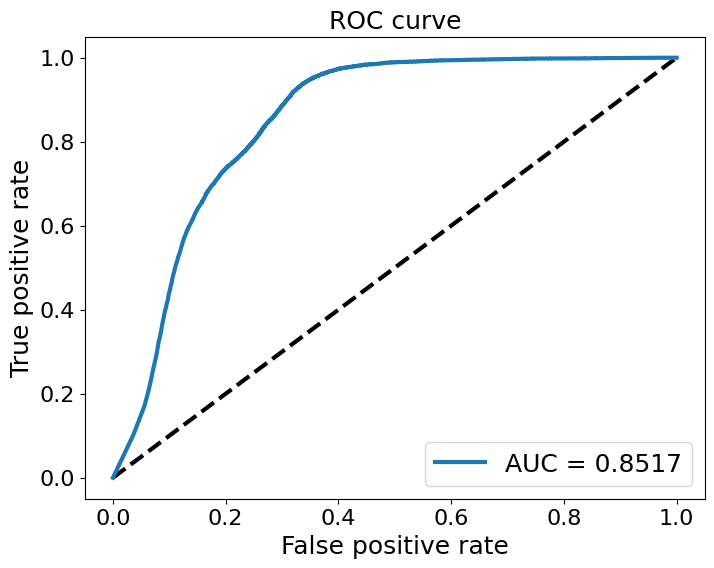

Confusion matrix, without normalization
[[16690  7056]
 [ 1858 13814]]


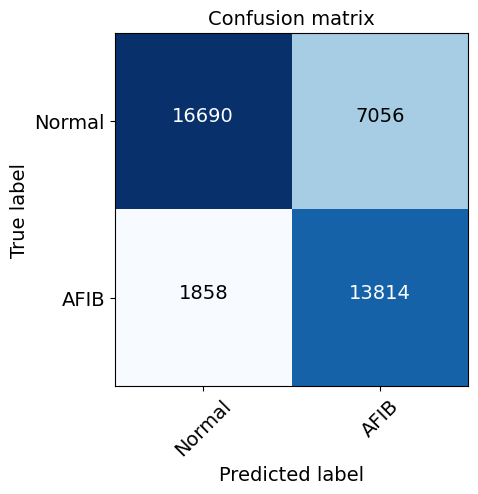

appended metrics


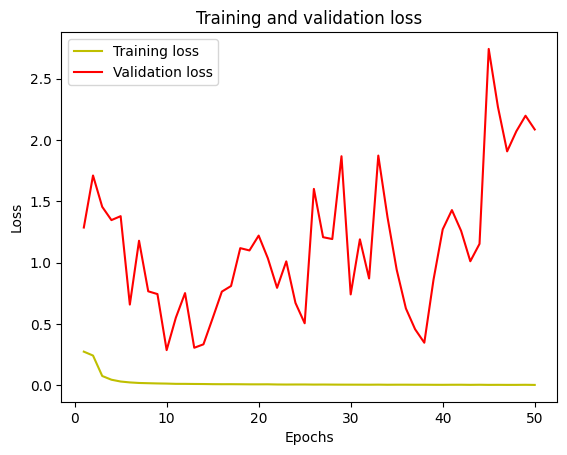

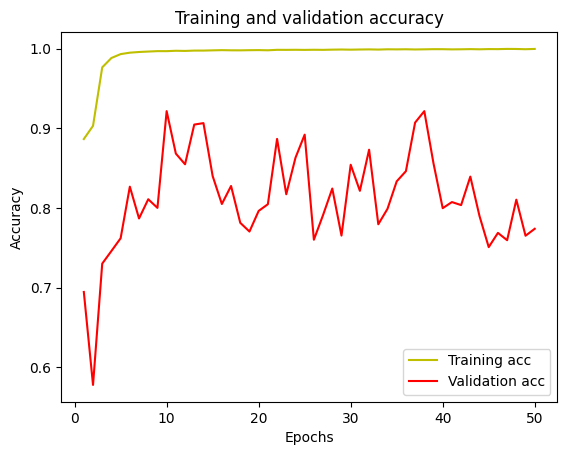

In [5]:

print(os.getcwd())
   
os.chdir(startdir)
path="./data/afdb/robust_ol5_win12/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

#reshape data: 
# reshape input to be [samples, time steps, features = 1]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

os.chdir(startdir+'/results/180403')

model = buildBest_2()

#history = model.fit(x_train, y_train, epochs=3)
#mask_tensor = model.layers[1].compute_mask(x_train)

split_train_eval(model, 50, 32)

## Retrain fixed length (3000) w/ pr window MinMax for 50 epochs instead of 20/25

/work/ECG_masters
[[0.95566204 0.95441029 0.9445826  0.92804699 0.91154465 0.89885678
  0.89206761 0.89044755 0.88028804 0.87673453]
 [0.90961995 0.91536149 0.91473719 0.90322949 0.90429605 0.9015827
  0.89401042 0.90073549 0.89424735 0.89196487]
 [0.77405788 0.62579507 0.41641536 0.20802515 0.06340402 0.00164232
  0.0138168  0.16463854 0.44720267 0.7039701 ]
 [0.54158374 0.35701932 0.21282225 0.12510732 0.11050457 0.18056996
  0.35661581 0.60765383 0.8014488  0.87709272]
 [0.92741834 0.93682338 0.93062529 0.93256313 0.93084189 0.92738367
  0.92818798 0.92072592 0.92522376 0.92534017]]
Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 2998, 32)          128       
                                                              

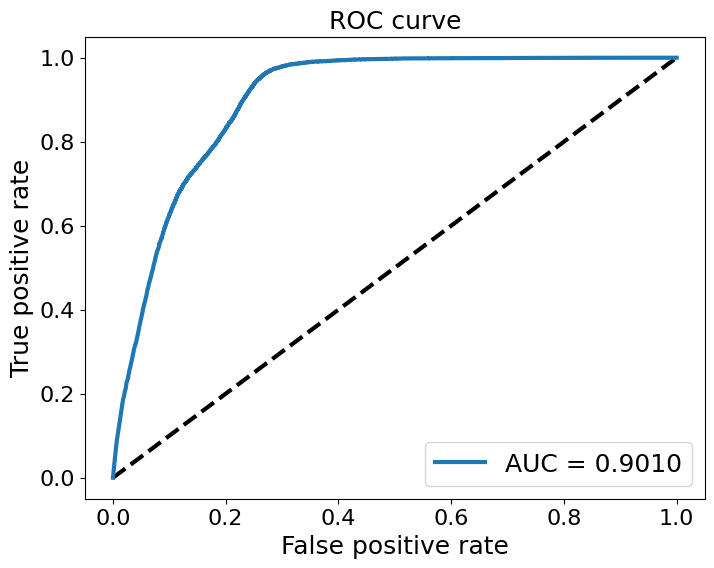

Confusion matrix, without normalization
[[18593  5153]
 [ 2110 13562]]


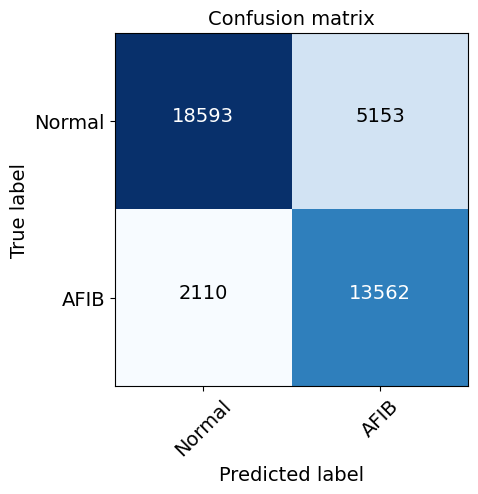

appended metrics


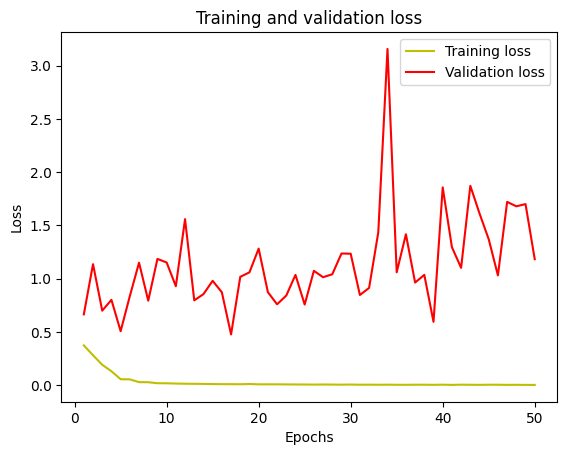

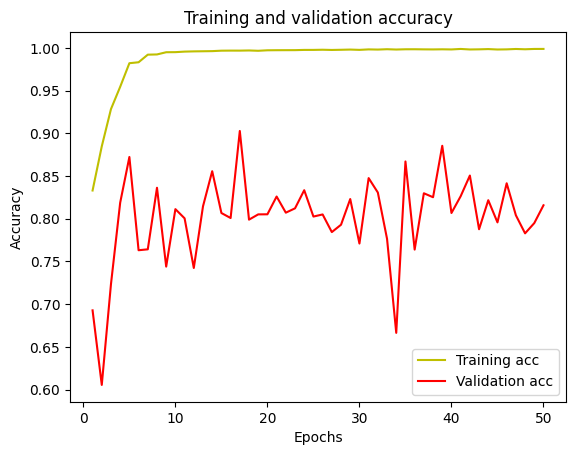

In [12]:


print(os.getcwd())
   
os.chdir(startdir)
path="./data/afdb/winNorm_ol5_win12/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)


print(X[200:205,100:110])
#reshape data: 
# reshape input to be [samples, time steps, features = 1]

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

os.chdir(startdir+'/results/180404')

model = buildBest_2()

#history = model.fit(x_train, y_train, epochs=3)
#mask_tensor = model.layers[1].compute_mask(x_train)

split_train_eval(model, 50, 32)


In [11]:
#reshape data: 
# reshape input to be [samples, time steps, features = 1]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))


(128044,)
(128044, 3000, 1)
(128044, 2)


In [32]:
values, counts = np.unique(y[:,0], return_counts=True)
df = pd.DataFrame({'label':values, 'val':counts})
print(df.groupby('label').val.sum())

label
0    51969
1    76075
Name: val, dtype: int64


In [ ]:
%run "models.ipynb" 
%run "tools.ipynb" 

## Investigate what happens if data is pooled and shuffled i.e no regards to ID. This segment just to check if code runs properly. Actual analysis run in Colab


[array([-0.010268  ,  0.00717621,  0.00207765, -0.01793759, -0.00454042,
       -0.00261695,  0.00273332, -0.02055306,  0.00553488,  0.01364676,
        0.02778696,  0.02182063,  0.0224542 ,  0.03450591,  0.02751846,
        0.01469171, -0.00515852, -0.01388919, -0.01221044, -0.00695517,
        0.04711071,  0.03988329,  0.0539866 ,  0.02100114,  0.02492877]), array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]), array([1, 1, 1, 1, 1])]
Fold 0:
***
[array([-0.010268  ,  0.00717621,  0.00207765, -0.01793759, -0.00454042,
       -0.00261695,  0.00273332, -0.02055306,  0.00553488,  0.01364676,
        0.02778696,  0.02182063,  0.0224542 ,  0.03450591,  0.02751846,
        0.01469171, -0.00515852, -0.01388919, -0.01221044, -0.00695517,
        0.04711071,  0.03988329,  0.0539866 ,  0.02100114,  0.02492877]), array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]), array([1, 1, 1, 1, 1])]
***
  Train: index=[   0    1    2 ... 4997 4998 4999]
  Test:  index=[   3   14   19   20   25   27   46   49   54   55   56   62   66 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


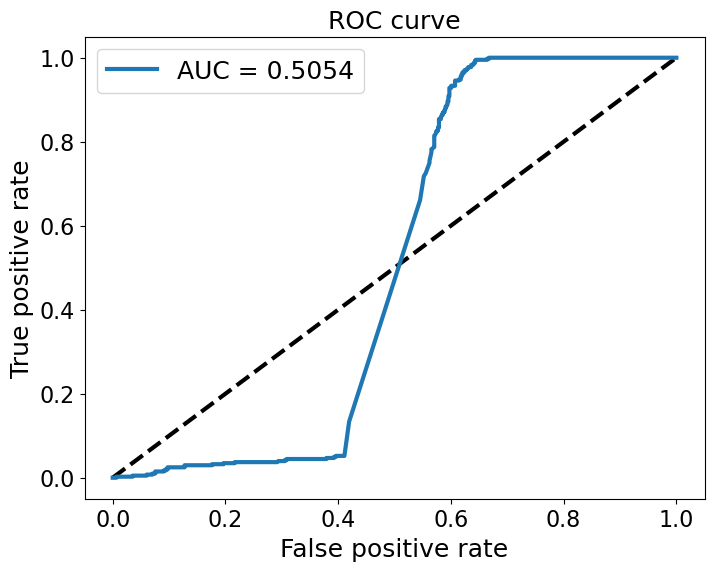

Confusion matrix, without normalization
[[596   0]
 [404   0]]


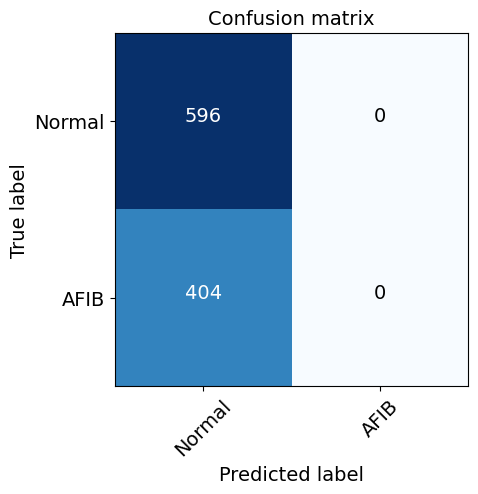

appended metrics
Fold 1:
***
[array([-0.010268  ,  0.00717621,  0.00207765, -0.01793759, -0.00454042,
       -0.00261695,  0.00273332, -0.02055306,  0.00553488,  0.01364676,
        0.02778696,  0.02182063,  0.0224542 ,  0.03450591,  0.02751846,
        0.01469171, -0.00515852, -0.01388919, -0.01221044, -0.00695517,
        0.04711071,  0.03988329,  0.0539866 ,  0.02100114,  0.02492877]), array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]), array([1, 1, 1, 1, 1])]
***
  Train: index=[   0    1    2 ... 4994 4995 4998]
  Test:  index=[   6   10   22   26   32   33   37   40   43   51   68   75   78   92
   93   97  103  109  112  117  124  131  132  135  136  138  145  154
  161  162  173  174  176  177  179  180  218  227  233  236  244  247
  248  249  254  257  261  262  263  269  280  281  285  291  299  303
  312  313  315  318  321  324  325  329  331  333  336  337  348  349
  351  353  356  365  381  383  388  391  406  420  428  437  438  440
  447  450  471  479  490  491  492  495  508  51

KeyboardInterrupt: 

In [8]:
# investigate what happens if data is pooled and shuffled i.e no regards to ID. This segment just to check if code runs properly.

os.chdir(startdir)
    
path='./data/afdb/prBt20_trunc75_noScale/'

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

X=X[:5000,:]
y=y[:5000,:]
#os.chdir(startdir+'/results/prBt20Global_'+mode[1])   

#make non-oneHOtencoded y copy to stratify on. What will happen when shuffling. Check underway...
y_str = y[:,0]

print([X[111:116,:5].flatten(), y[111:116,:].flatten(),y_str[111:116]])
#model = build_mask_best()
#model = build_explore(1, denseLayers=1, typeLSTM='1 LSTM', dropout=False)
stratKfold_eval('best_mask', 1, build_mask_best, BATCH=256)

#it seems to be ok 

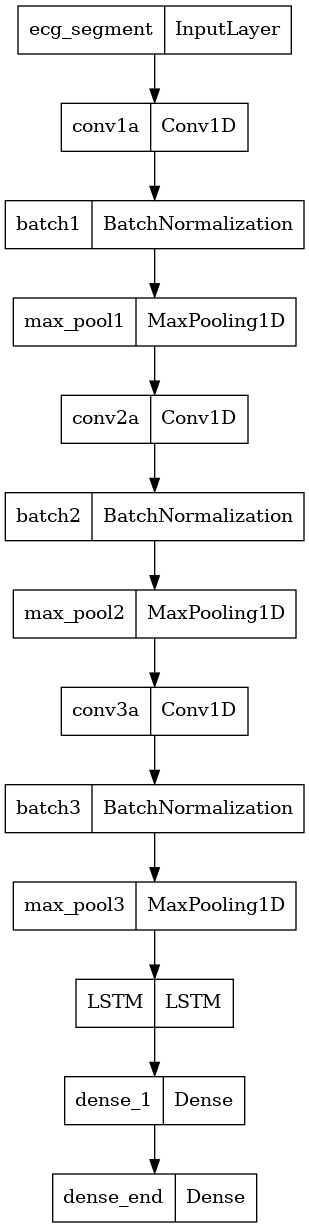

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='multiple_outputs.png')


In [39]:
from keras.utils import plot_model

In [10]:
conda install -c conda-forge graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       hd4edc92_1         539 KB  conda-forge
    gdk-pixbuf-2.42.10         |       h6b639ba_2         560 KB  conda-forge
    giflib-5.2.1               |       h0b41bf4_3          76 KB  conda-forge
    graphviz-8.0.3             |       h2e5815a_0         2.2 MB  conda-forge
    gtk2-2.24.33               |       h90689f9_2         7.4 MB  conda-forge
    gts-0.7.6                  |       h64030ff_2  

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 conv1a (Conv1D)             (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 2798, 64)          0

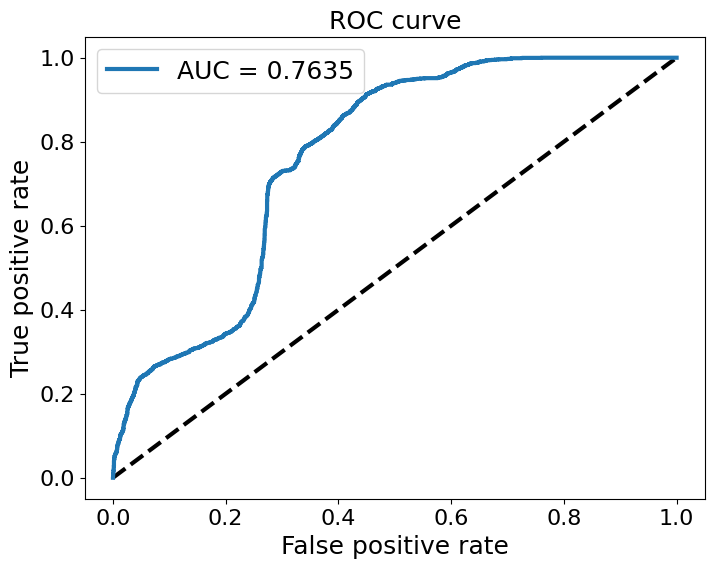

Confusion matrix, without normalization
[[2132 1295]
 [ 451 2059]]


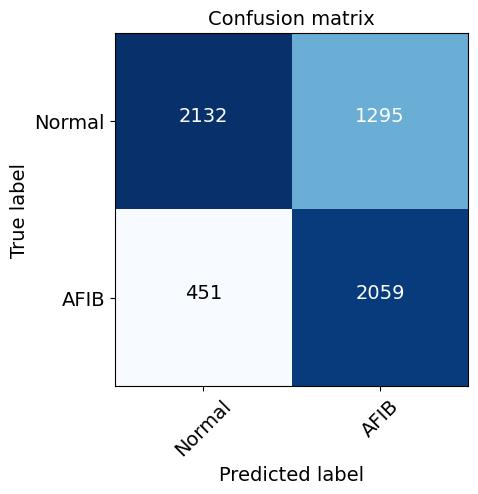

appended metrics


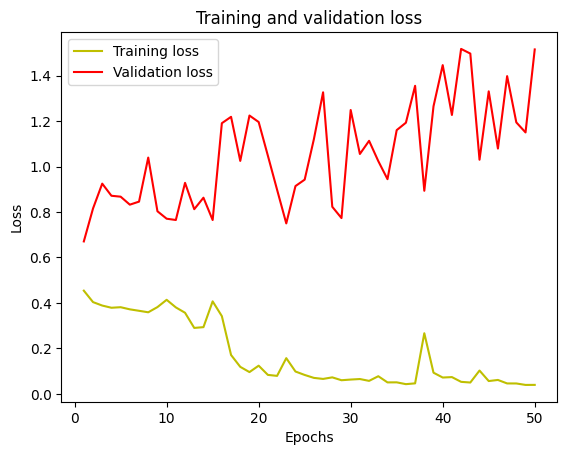

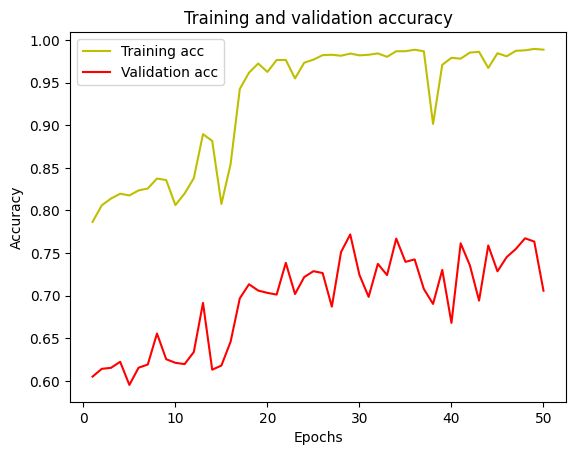

*****new model***
running model: biLSTM
made dir biLSTM
shape of x_train: (12860, 11202, 1), type: <class 'numpy.ndarray'>
shape of x_test: (5937, 11202, 1), type: <class 'numpy.ndarray'>
Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1398, 2) vs (None, 2)).


In [16]:
#investigate new models using prBt60
from keras.utils import plot_model

os.chdir(startdir)
path="./data/afdb/prBt60_trunc60_robust/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

buildList=[ 
        [build_explore(1, denseLayers=5, typeLSTM='1 LSTM', dropout=False),'dense5'],
        [build_explore(1, denseLayers=1, typeLSTM='biLSTM', dropout=False), 'biLSTM'],
        [build_explore(1, denseLayers=1, typeLSTM='2 LSTM', dropout=False),'2LSTM'],
        [build_explore(2, denseLayers=1, typeLSTM='1 LSTM', dropout=False),'filltop'],
        [build_explore(2, denseLayers=1, typeLSTM='1 LSTM', dropout=True),'filltop_dropout'],
        [build_explore(1, denseLayers=1, typeLSTM='BiLSTM', dropout=True),'biLSTM_dropout'],
        [build_explore(1, denseLayers=1, typeLSTM='1 LSTM', dropout=True),'dropout']   
           ]

for build in buildList:
    os.chdir(startdir)
    model = build[0] 
    print('*****new model***')
    print('running model: '+build[1] )
    #plot_model(model, to_file='multiple_outputs.png')
    
    try:
        os.mkdir('./results/newmodels/'+build[1])
        print('made dir '+build[1])
    except OSError as error:
        print('dir already exists')
        pass                
       
    os.chdir('./results/newmodels/'+build[1]+'/')

    split_train_eval(model, 50, 128)
  


## investigate if models behave different depending on shuffle during fit and which model is built..

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 conv1a (Conv1D)             (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 2798, 64)          0

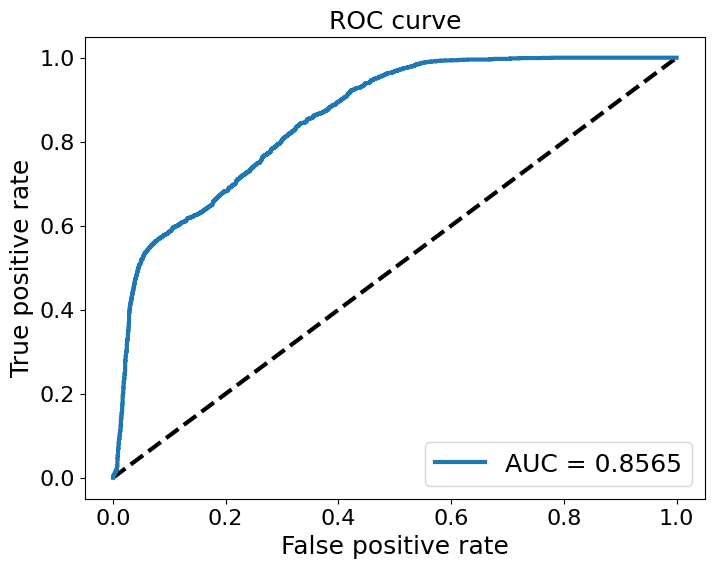

Confusion matrix, without normalization
[[3016  411]
 [ 990 1520]]


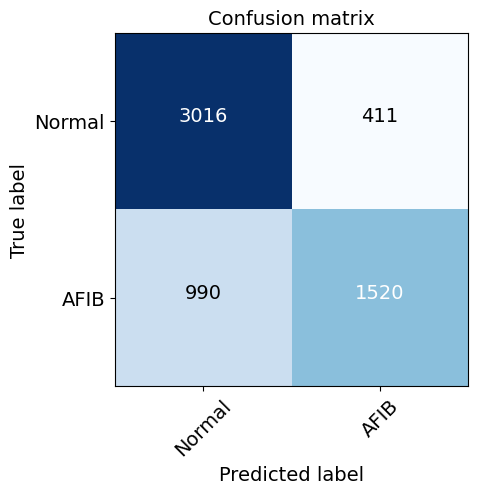

appended metrics


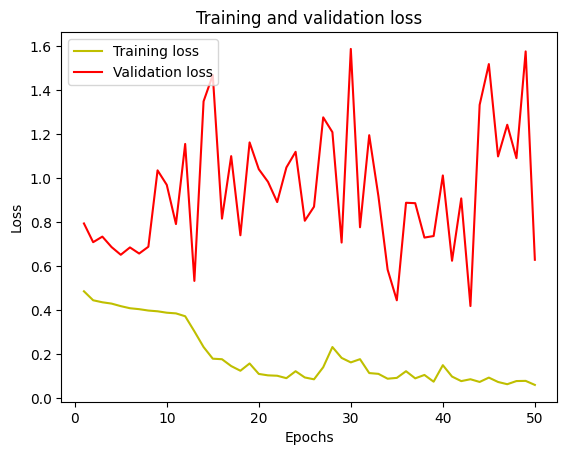

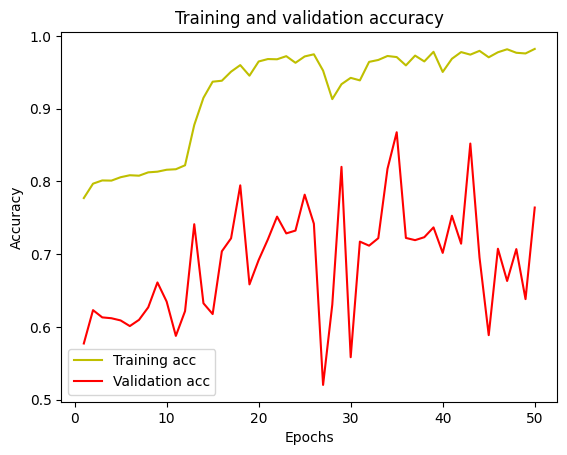

dir already exists
shape of x_train: (12860, 11202, 1), type: <class 'numpy.ndarray'>
shape of x_test: (5937, 11202, 1), type: <class 'numpy.ndarray'>
Epoch 1/50
101/101 [==============================] - 15s 116ms/step - loss: 0.5095 - accuracy: 0.8279 - val_loss: 1.5125 - val_accuracy: 0.6084
Epoch 2/50
101/101 [==============================] - 11s 109ms/step - loss: 0.4420 - accuracy: 0.8143 - val_loss: 0.4103 - val_accuracy: 0.8114
Epoch 3/50
101/101 [==============================] - 11s 108ms/step - loss: 0.1725 - accuracy: 0.9520 - val_loss: 1.2724 - val_accuracy: 0.5942
Epoch 4/50
101/101 [==============================] - 11s 109ms/step - loss: 0.1337 - accuracy: 0.9616 - val_loss: 0.3986 - val_accuracy: 0.8663
Epoch 5/50
101/101 [==============================] - 11s 109ms/step - loss: 0.1123 - accuracy: 0.9684 - val_loss: 1.4743 - val_accuracy: 0.5285
Epoch 6/50
101/101 [==============================] - 11s 109ms/step - loss: 0.3224 - accuracy: 0.8762 - val_loss: 1.1209 - 

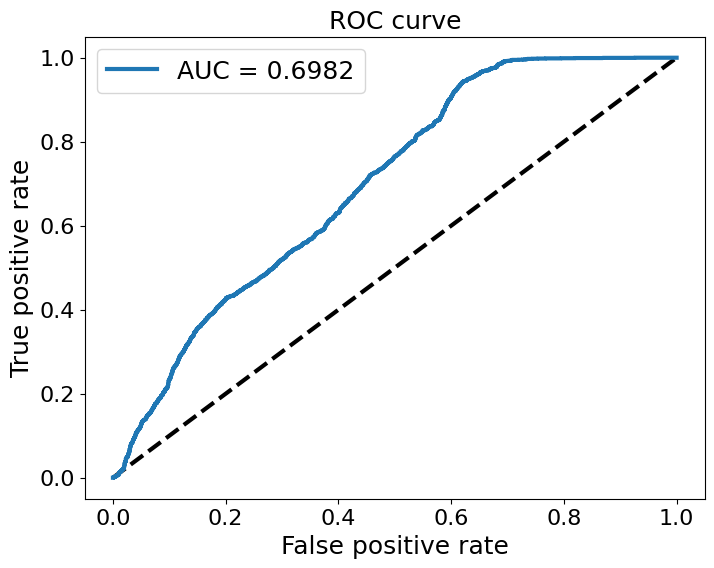

Confusion matrix, without normalization
[[1841 1586]
 [ 688 1822]]


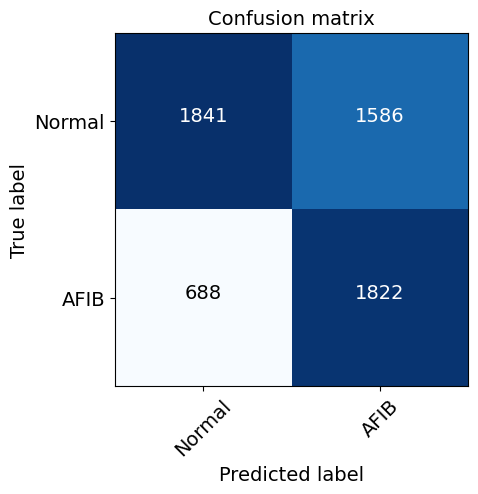

appended metrics


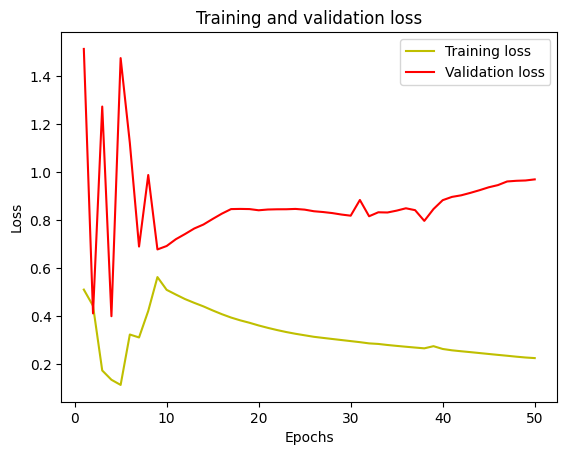

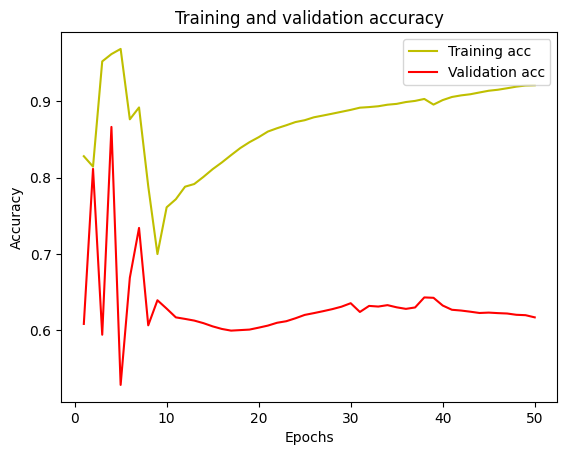

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         2

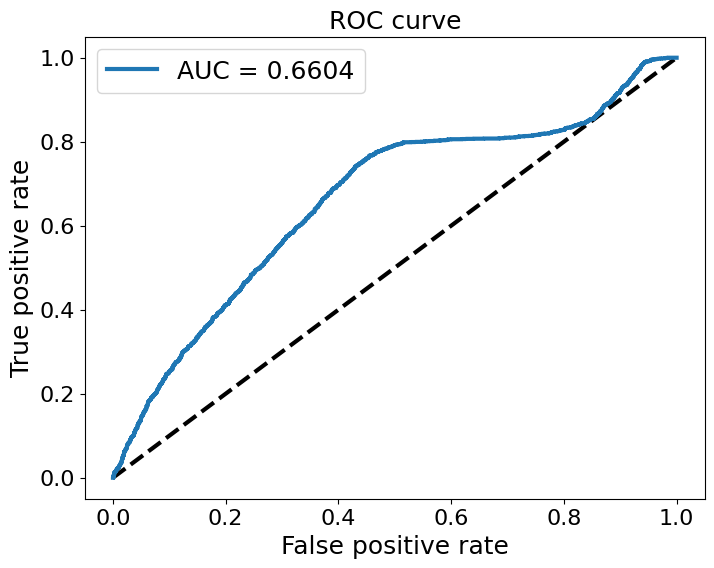

Confusion matrix, without normalization
[[1807 1620]
 [ 558 1952]]


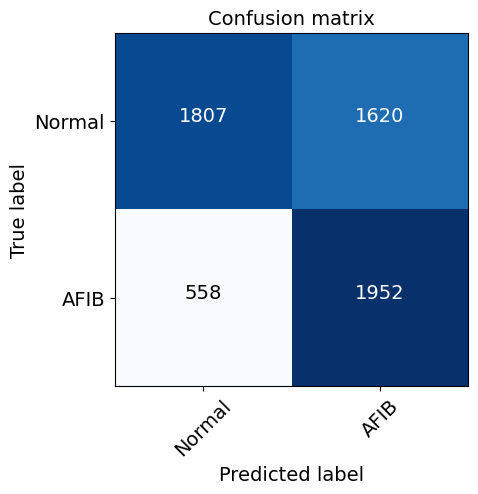

appended metrics


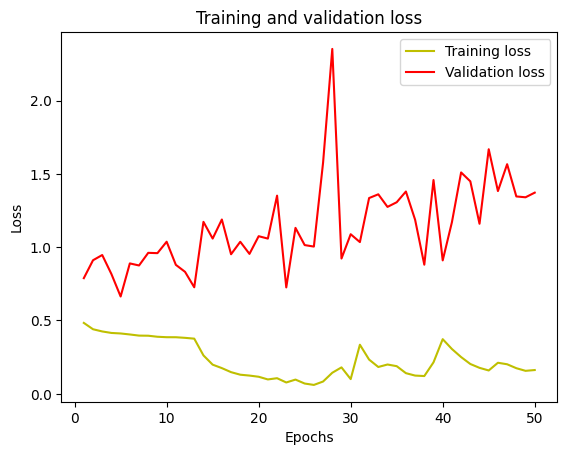

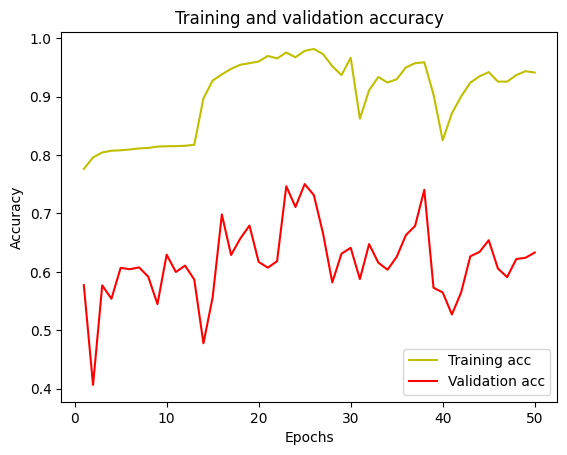

"\nDenseLayers: 1-6\nincl dropout\n2 LSTM, biLSTM, 1 LSTM\nbuild_explore(1, denseLayers=4, typeLSTM='1 LSTM', dropout=False)\nbuild_explore(1, denseLayers=4, typeLSTM='1 LSTM', dropout=False)\ntop=1/2\n"

In [29]:

os.chdir(startdir)
path="./data/afdb/prBt60_trunc60_overlap0/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

buildList=[ 
         [build_explore(1, denseLayers=1, typeLSTM='1 LSTM', dropout=False), 'base_model'],
               ]

for build in buildList:
    os.chdir(startdir)
    model = build[0] 
    print('*****new model***')
    print('running model: '+build[1] )
    #plot_model(model, to_file='multiple_outputs.png')
    
    try:
        os.mkdir('./results/newmodels/'+build[1]+'_shuffle')
        print('made dir '+build[1])
    except OSError as error:
        print('dir already exists')
        pass                
       
    os.chdir('./results/newmodels/'+build[1]+'_shuffle/')
    #rebuild to reset weights 
    model = build[0] 
    split_train_eval(model, 50, 128,True)
    os.chdir(startdir)
    
    try:
        os.mkdir('./results/newmodels/'+build[1]+'_noshuffle')
        print('made dir '+build[1])
    except OSError as error:
        print('dir already exists')
        pass                
    
    os.chdir('./results/newmodels/'+build[1]+'_noshuffle/')
    split_train_eval(model, 50, 128,False)

#is something wrong with the model? results look weird
os.chdir(startdir)
model = build_mask_best()
os.chdir('./test/')
split_train_eval(model, 50, 128,True)

"""
DenseLayers: 1-6
incl dropout
2 LSTM, biLSTM, 1 LSTM
build_explore(1, denseLayers=4, typeLSTM='1 LSTM', dropout=False)
build_explore(1, denseLayers=4, typeLSTM='1 LSTM', dropout=False)
top=1/2
"""

## can I reproduce results?

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         2

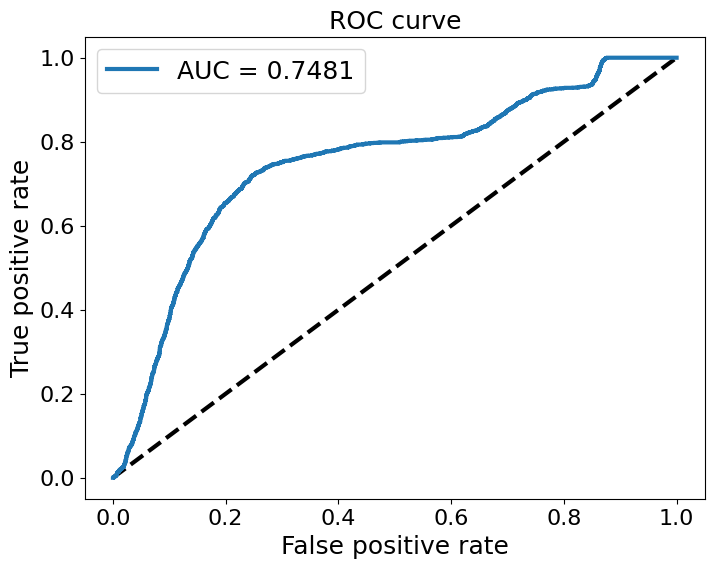

Confusion matrix, without normalization
[[2142 1285]
 [ 566 1944]]


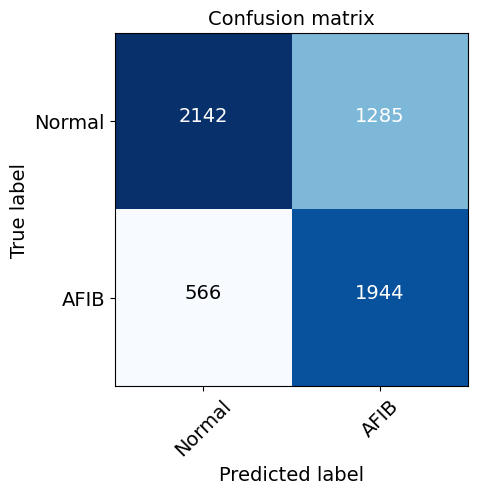

appended metrics


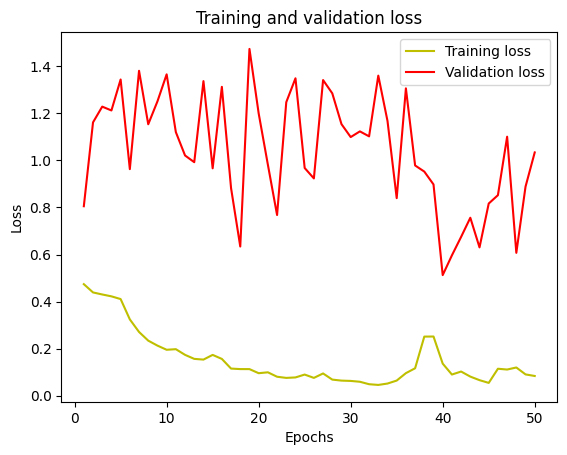

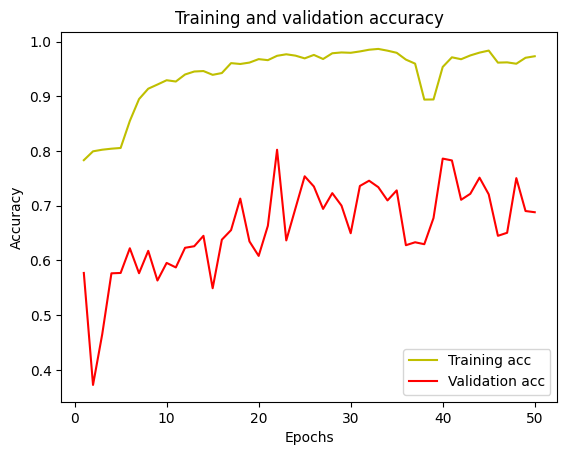

In [33]:

os.chdir(startdir)
path="./data/afdb/prBt60_trunc60_overlap0/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

model = build_mask_best()
os.chdir('./test/')
split_train_eval(model, 50, 128)


#### rerun same as above to test if I can reproduce results?

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5596, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 5596, 64)         2

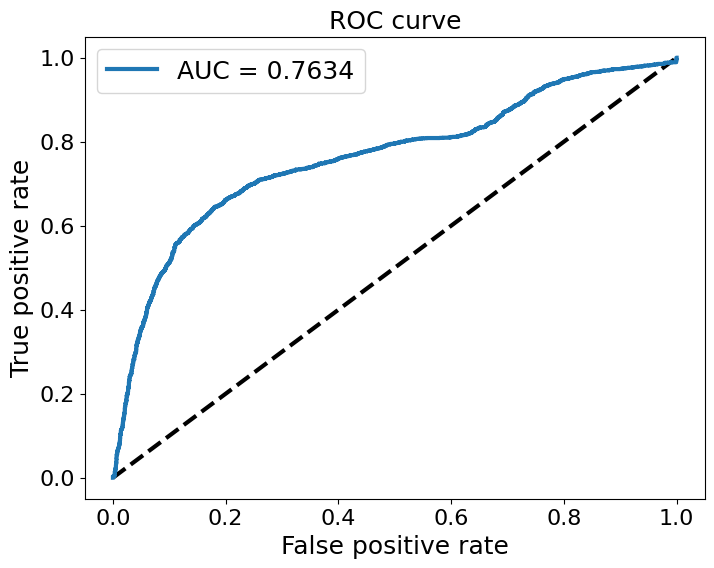

Confusion matrix, without normalization
[[2138 1289]
 [ 629 1881]]


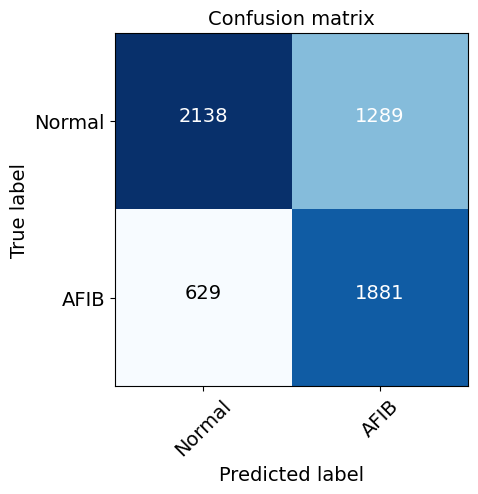

appended metrics


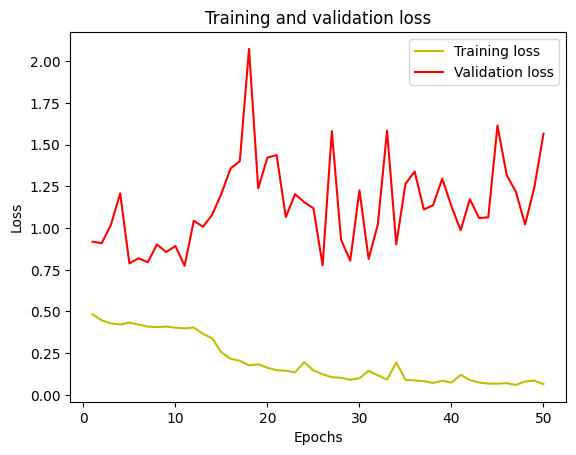

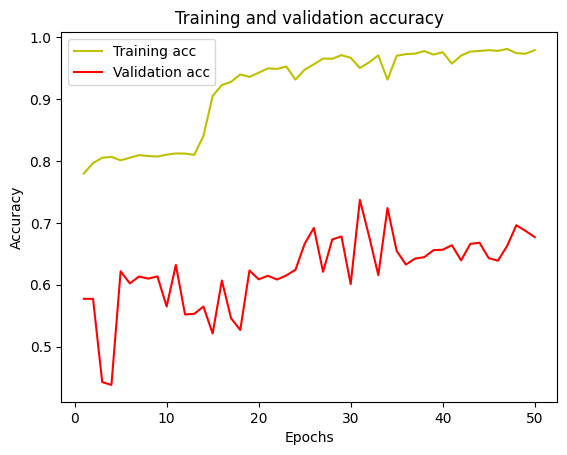

In [34]:

os.chdir(startdir)
path="./data/afdb/prBt60_trunc60_overlap0/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

model = build_mask_best()
os.chdir('./retest/')
split_train_eval(model, 50, 128)

# investigate new models.#investigate new models using prBt20_robust (MinMax pr window)

would be idea to do so using CV to make sure that models get a fair chance 

In [12]:

from keras.utils import plot_model

os.chdir(startdir)
path="./data/afdb/prBt20_trunc75/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

buildList=[ 
        #[build_explore(1, denseLayers=5, typeLSTM='1 LSTM', dropout=False),'dense5'],
        #[build_explore(1, denseLayers=1, typeLSTM='1 biLSTM', dropout=False), '1 biLSTM'],
        #[build_explore(1, denseLayers=1, typeLSTM='2 LSTM', dropout=False),'2LSTM'],
        #[build_explore(2, denseLayers=1, typeLSTM='1 LSTM', dropout=False),'filltop'],
        #[build_explore(2, denseLayers=1, typeLSTM='1 LSTM', dropout=True),'filltop_dropout'],
        #[build_explore(1, denseLayers=1, typeLSTM='1 biLSTM', dropout=True),'biLSTM_dropout'],
        [build_explore(1, denseLayers=1, typeLSTM='1 LSTM', dropout=True),'dropout']   
           ]

for build in buildList:
    os.chdir(startdir)
    model = build[0] 
    print('*****new model***')
    print('running model: '+build[1] )
    #plot_model(model, to_file='multiple_outputs.png')
    
    try:
        os.mkdir('./results/newmodels/'+build[1])
        print('made dir '+build[1])
    except OSError as error:
        print('dir already exists')
        pass                
       
    os.chdir('./results/newmodels/'+build[1]+'/')

    split_train_eval(model, 50, 128, True)
  

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1a (Conv1D)             (None, 4129, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 4129, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2065, 32)          0         
                                                                 
 dropout_18 (Dropout)        (None, 2065, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 2061, 64)          1

2023-05-03 13:27:39.175059: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 13:27:39.176966: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 13:27:39.178061: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

*****new model***
running model: dropout
dir already exists
shape of x_train: (38595, 4131, 1), type: <class 'numpy.ndarray'>
shape of x_test: (17820, 4131, 1), type: <class 'numpy.ndarray'>
Epoch 1/50


2023-05-03 13:27:40.725017: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 13:27:40.726431: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 13:27:40.728014: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

256/302 [========================>.....] - ETA: 2s - loss: 0.4735 - accuracy: 0.7589

KeyboardInterrupt: 

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         


2023-05-03 12:27:01.135227: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:27:01.137332: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:27:01.138468: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1a (Conv1D)             (None, 4129, 32)          128       
                                                                 
 conv1b (Conv1D)             (None, 4127, 32)          3104      
                                                                 
 batch1 (BatchNormalization)  (None, 4127, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2064, 32)          0         
                                                                 
 dropout_3 (Dropout)         (None, 2064, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 2060, 64)          10304     
                                                                 
 conv2b (C

2023-05-03 12:27:02.970754: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:27:02.972212: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:27:02.973984: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

302/302 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8364

2023-05-03 12:27:31.221587: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:27:31.222825: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:27:31.224545: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

302/302 [==============================] - 33s 89ms/step - loss: 0.3624 - accuracy: 0.8364 - val_loss: 1.9144 - val_accuracy: 0.5777
Epoch 2/50
302/302 [==============================] - 26s 87ms/step - loss: 0.2381 - accuracy: 0.9097 - val_loss: 1.0884 - val_accuracy: 0.6444
Epoch 3/50
302/302 [==============================] - 26s 86ms/step - loss: 0.2256 - accuracy: 0.9149 - val_loss: 1.1489 - val_accuracy: 0.5767
Epoch 4/50
302/302 [==============================] - 26s 85ms/step - loss: 0.2676 - accuracy: 0.8923 - val_loss: 1.1208 - val_accuracy: 0.6188
Epoch 5/50
302/302 [==============================] - 26s 85ms/step - loss: 0.2069 - accuracy: 0.9227 - val_loss: 1.1437 - val_accuracy: 0.5827
Epoch 6/50
302/302 [==============================] - 26s 87ms/step - loss: 0.2073 - accuracy: 0.9219 - val_loss: 0.8782 - val_accuracy: 0.6166
Epoch 7/50
302/302 [==============================] - 26s 86ms/step - loss: 0.1529 - accuracy: 0.9434 - val_loss: 1.0494 - val_accuracy: 0.6570
Epo

2023-05-03 12:48:22.054552: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:48:22.055982: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:48:22.057731: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

557/557 [==============================] - 12s 20ms/step
[[0.54019964 0.45835736]
 [0.97317874 0.02642355]
 [0.08369262 0.9171565 ]
 [0.9985343  0.00145829]
 [0.9832855  0.01662691]
 [0.14083889 0.86036015]
 [0.84933436 0.15096448]
 [0.0025321  0.99745053]
 [0.0040698  0.99588853]
 [0.55727726 0.4447535 ]]
using probability for having AFIB
[0.45835736 0.02642355 0.9171565  0.00145829 0.01662691 0.86036015
 0.15096448 0.99745053 0.99588853 0.4447535 ]
y_pred_cl
[0 0 1 0 0 1 0 1 1 0]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_test
[0 0 0 0 0 0 0 0 0 0]


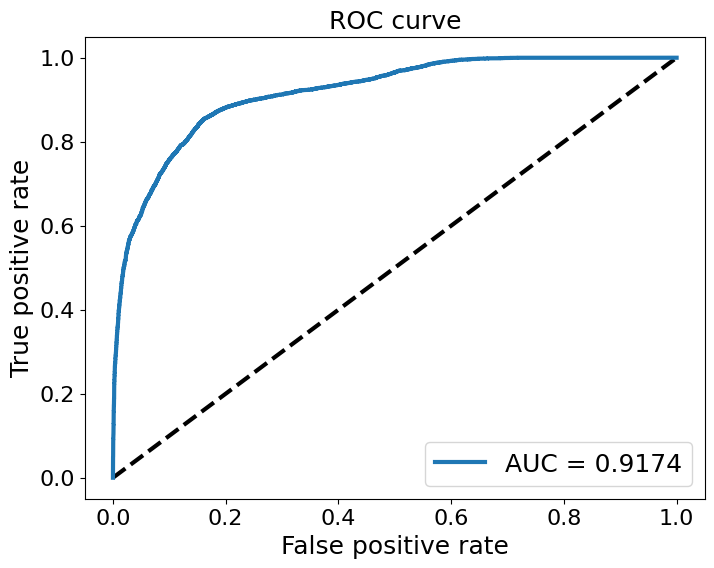

Confusion matrix, without normalization
[[9622  673]
 [2445 5080]]


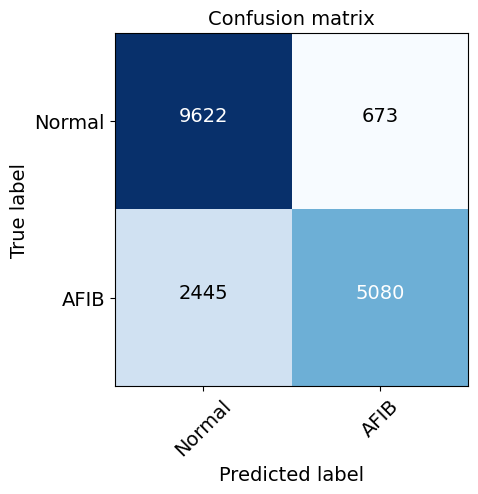

appended metrics


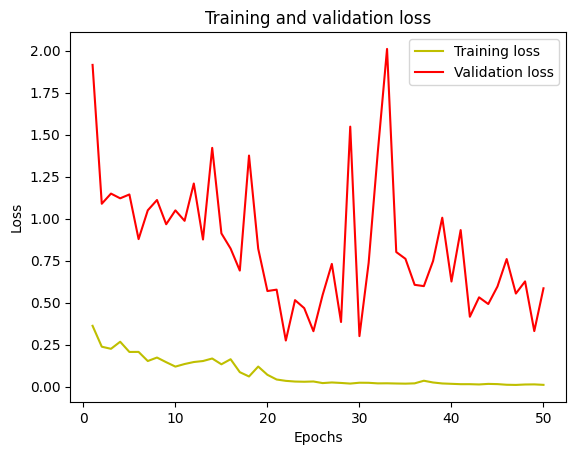

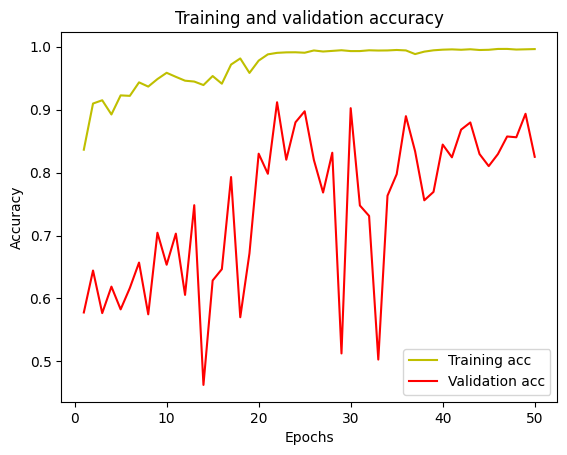

Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-05-03 12:48:35.472422: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:48:35.473733: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:48:35.475261: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1a (Conv1D)             (None, 4129, 32)          128       
                                                                 
 conv1b (Conv1D)             (None, 4127, 32)          3104      
                                                                 
 batch1 (BatchNormalization)  (None, 4127, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2064, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 2060, 64)          10304     
                                                                 
 conv2b (Conv1D)             (None, 2056, 64)          20544     
          

2023-05-03 12:48:37.196249: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:48:37.197686: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:48:37.199589: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

302/302 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8871

2023-05-03 12:49:05.507877: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 12:49:05.509219: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 12:49:05.510806: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

302/302 [==============================] - 32s 89ms/step - loss: 0.2804 - accuracy: 0.8871 - val_loss: 1.9646 - val_accuracy: 0.5777
Epoch 2/50
302/302 [==============================] - 26s 86ms/step - loss: 0.1899 - accuracy: 0.9292 - val_loss: 1.2426 - val_accuracy: 0.6129
Epoch 3/50
302/302 [==============================] - 26s 87ms/step - loss: 0.2306 - accuracy: 0.9082 - val_loss: 1.1204 - val_accuracy: 0.6263
Epoch 4/50
302/302 [==============================] - 25s 83ms/step - loss: 0.1490 - accuracy: 0.9435 - val_loss: 1.0284 - val_accuracy: 0.6553
Epoch 5/50
302/302 [==============================] - 24s 80ms/step - loss: 0.1729 - accuracy: 0.9340 - val_loss: 0.7770 - val_accuracy: 0.7191
Epoch 6/50
302/302 [==============================] - 24s 79ms/step - loss: 0.1799 - accuracy: 0.9339 - val_loss: 0.9738 - val_accuracy: 0.7220
Epoch 7/50
302/302 [==============================] - 24s 80ms/step - loss: 0.1650 - accuracy: 0.9392 - val_loss: 1.3764 - val_accuracy: 0.6383
Epo

2023-05-03 13:10:05.553117: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 13:10:05.554507: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 13:10:05.556177: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

557/557 [==============================] - 13s 21ms/step
[[0.02632859 0.9737803 ]
 [0.07133508 0.9281549 ]
 [0.02854927 0.97163624]
 [0.22110316 0.78396577]
 [0.2985973  0.7119292 ]
 [0.0662007  0.93318284]
 [0.02787236 0.9724348 ]
 [0.04786326 0.95277333]
 [0.4128994  0.5829753 ]
 [0.05323732 0.9471567 ]]
using probability for having AFIB
[0.9737803  0.9281549  0.97163624 0.78396577 0.7119292  0.93318284
 0.9724348  0.95277333 0.5829753  0.9471567 ]
y_pred_cl
[1 1 1 1 1 1 1 1 1 1]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
y_test
[0 0 0 0 0 0 0 0 0 0]


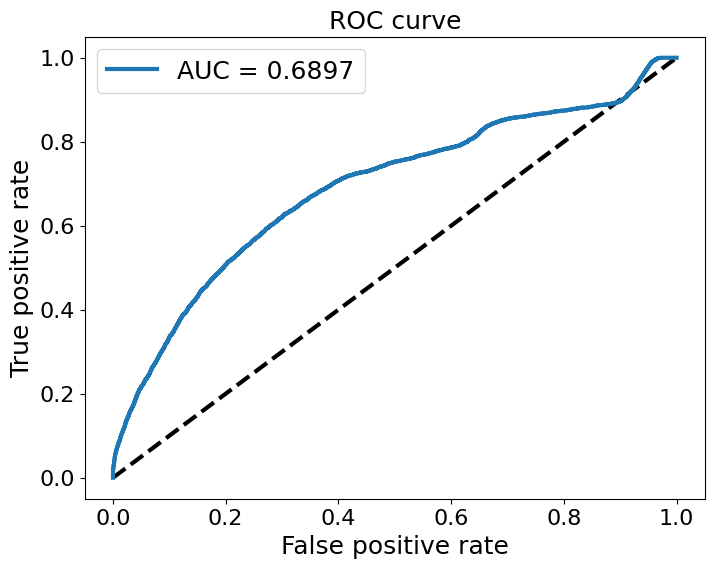

Confusion matrix, without normalization
[[5333 4962]
 [1932 5593]]


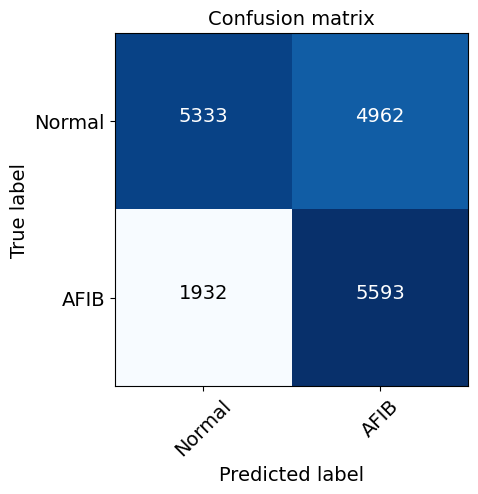

appended metrics


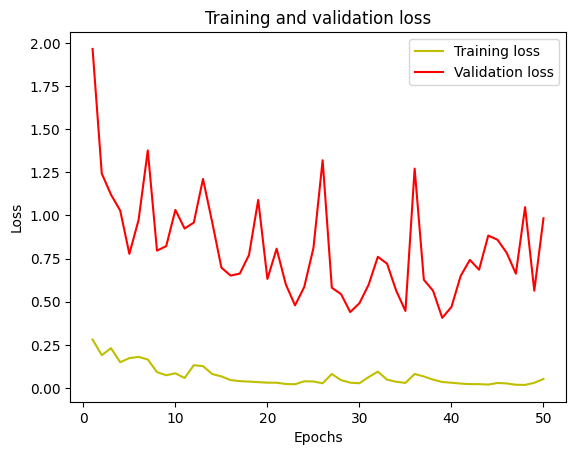

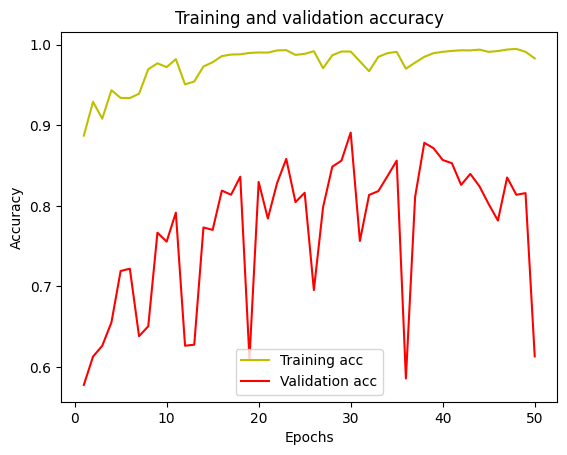

In [8]:
# add 2 more extra models 

os.chdir(startdir)
path="./data/afdb/prBt20_trunc75/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)


os.chdir(startdir+'/results/newmodels/new_bi_top_drop')   
model1 = build_explore(top=2, denseLayers=1, typeLSTM='1 biLSTM', dropout=True)    
split_train_eval(model1, 50, 128, True)


os.chdir(startdir+'/results/newmodels/new_bi_top')   
model2 = build_explore(top=2, denseLayers=1, typeLSTM='1 biLSTM', dropout=False)    
split_train_eval(model2, 50, 128, True)


In [ ]:
# add untuned base model 

os.chdir(startdir)
path="./data/afdb/prBt20_trunc75/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)


os.chdir(startdir+'/results/newmodels/baseUntuned')   
model = buildBaseMask()
split_train_eval(model, 50, 128, True)


Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4131, 1)]         0         
                                                                 
 Masking1 (Masking)          (None, 4131, 1)           0         
                                                                 
 conv1 (Conv1D)              (None, 4127, 32)          192       
                                                                 
 batch1 (BatchNormalization)  (None, 4127, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 2064, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 2060, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 2060, 64)         256   

In [8]:
from tempfile import TemporaryFile

y_pred_pkl = TemporaryFile()
y_test_pkl = TemporaryFile()
np.save(y_pred_pkl, y_pred_pr)
np.save(y_test_pkl, y_test)


NameError: name 'y_pred_pr' is not defined

## evaluate best performing fixed-length method on best new models
- MinMax_ol10_win16
- dense5, filltop and bi_top_drop

(55357,)
(55357, 4000, 1)
(55357, 2)
Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4000, 1)]         0         
                                                                 
 conv1a (Conv1D)             (None, 3998, 32)          128       
                                                                 
 batch1 (BatchNormalization)  (None, 3998, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1999, 32)          0         
                                                                 
 conv2a (Conv1D)             (None, 1997, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 1997, 64)         256       
                                                                 
 max_pool2 (MaxPool

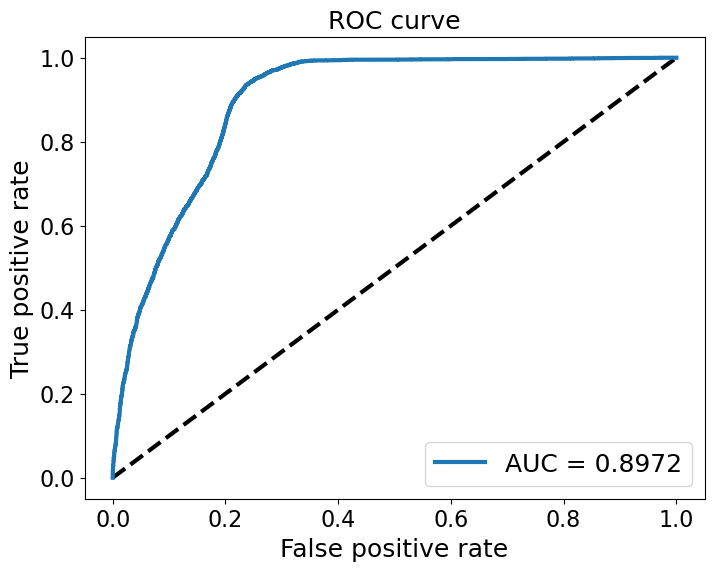

Confusion matrix, without normalization
[[7386 2901]
 [ 209 6539]]


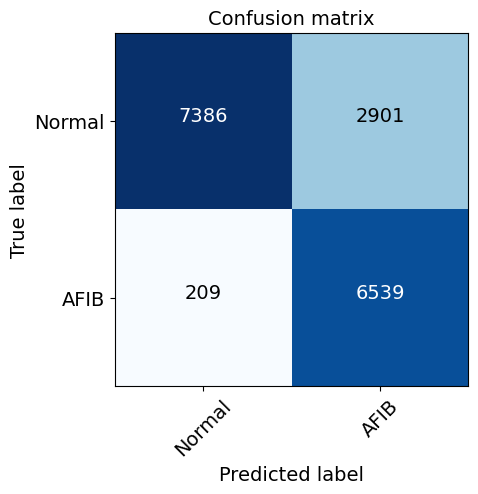

appended metrics


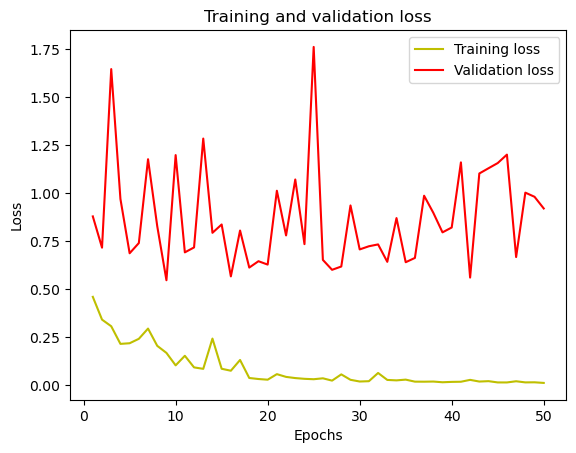

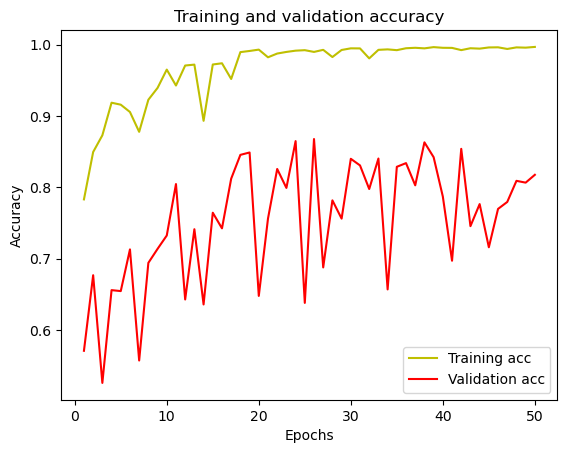

*****new model***
running model: bi_top_drop
made dir bi_top_drop
shape of x_train: (38322, 4000, 1), type: <class 'numpy.ndarray'>
shape of x_test: (17035, 4000, 1), type: <class 'numpy.ndarray'>
Epoch 1/50
1198/1198 [==============================] - 401s 332ms/step - loss: 0.4307 - accuracy: 0.7965 - val_loss: 0.7182 - val_accuracy: 0.5820
Epoch 2/50
1198/1198 [==============================] - 400s 334ms/step - loss: 0.3851 - accuracy: 0.8212 - val_loss: 0.6722 - val_accuracy: 0.7007
Epoch 3/50
1198/1198 [==============================] - 396s 331ms/step - loss: 0.3550 - accuracy: 0.8449 - val_loss: 0.6512 - val_accuracy: 0.7448
Epoch 4/50
1198/1198 [==============================] - 397s 332ms/step - loss: 0.5723 - accuracy: 0.7051 - val_loss: 0.8119 - val_accuracy: 0.5383
Epoch 5/50
1198/1198 [==============================] - 398s 332ms/step - loss: 0.4385 - accuracy: 0.7970 - val_loss: 1.1724 - val_accuracy: 0.4367
Epoch 6/50
1198/1198 [==============================] - 398s 33

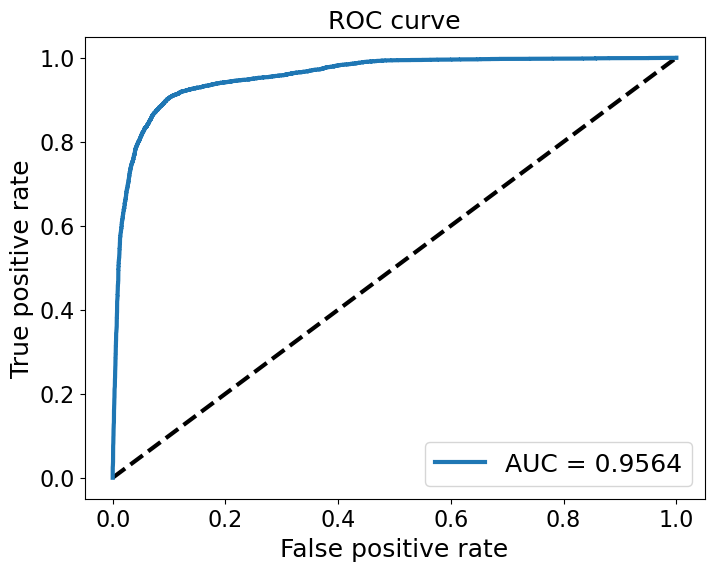

Confusion matrix, without normalization
[[8845 1442]
 [ 503 6245]]


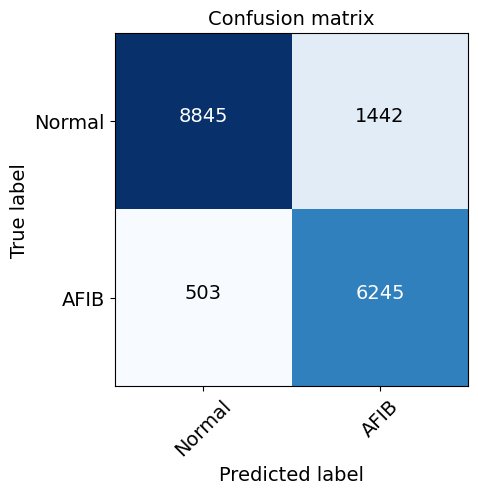

appended metrics


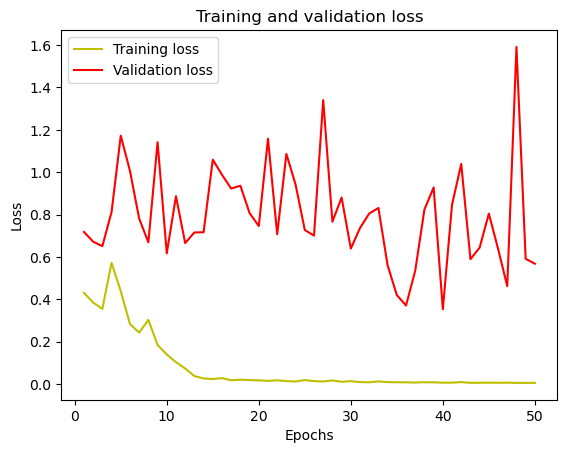

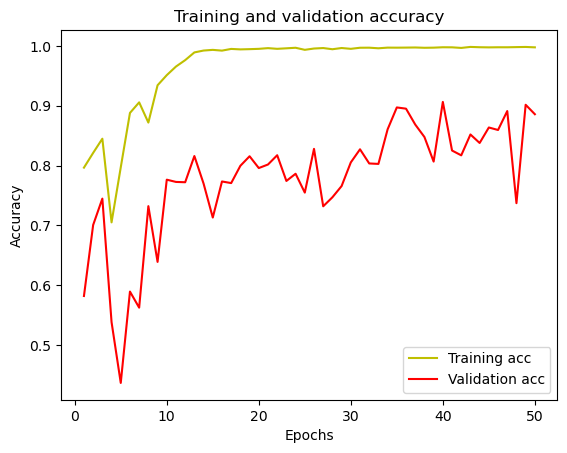

In [5]:
os.chdir(startdir)
path="./data/afdb/MinMax_ol01_win16/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)


#reshape data: 
# reshape input to be [samples, time steps, features = 1]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))

buildList=[ 
        [build_explore_fixed(2, denseLayers=1, typeLSTM='1 LSTM', dropout=False),'filltop'],
        [build_explore_fixed(1, denseLayers=5, typeLSTM='1 biLSTM', dropout=False),'dense5'],
        [build_explore_fixed(top=2, denseLayers=1, typeLSTM='1 biLSTM', dropout=True),'bi_top_drop' ]   
           ]

for build in buildList:
    os.chdir(startdir)
    model = build[0] 
    print('*****new model***')
    print('running model: '+build[1] )
        
    try:
        os.mkdir('./results/newmodels_fixed/'+build[1])
        print('made dir '+build[1])
    except OSError as error:
        print('dir already exists')
        pass                
       
    os.chdir('./results/newmodels_fixed/'+build[1]+'/')

    split_train_eval(model, 50, 32, True)

## evaluate untuned base model using fixed-length method 
- MinMax_ol10_win16

(55357,)
(55357, 4000, 1)
(55357, 2)
Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 3996, 32)          192       
                                                                 
 batch1 (BatchNormalization)  (None, 3996, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1998, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1994, 64)          10304     
                                                                 
 batch2 (BatchNormalization)  (None, 1994, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D

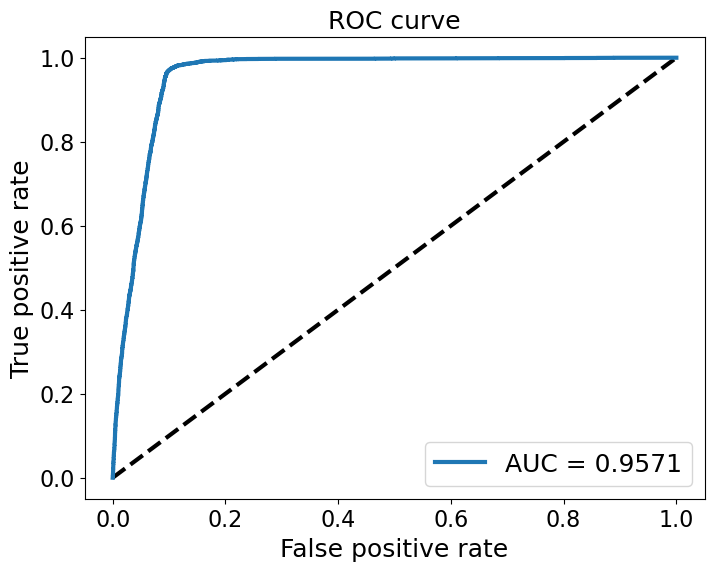

Confusion matrix, without normalization
[[8753 1534]
 [  76 6672]]


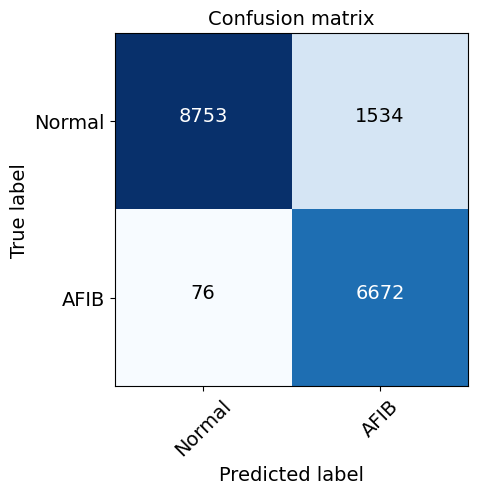

Normalized confusion matrix
[[85.08797511 14.91202489]
 [ 1.12625963 98.87374037]]


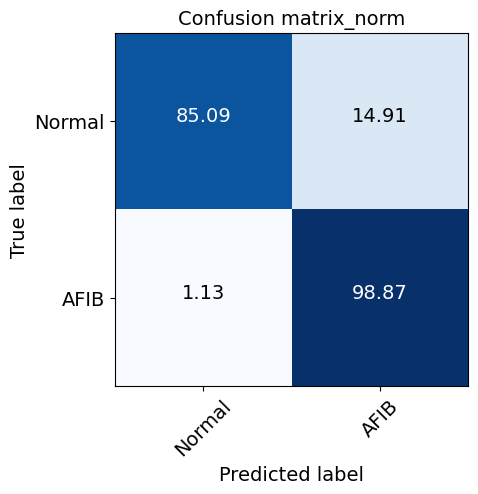

appended metrics


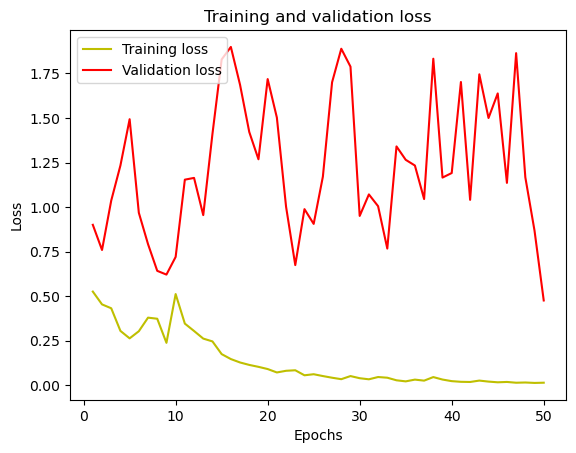

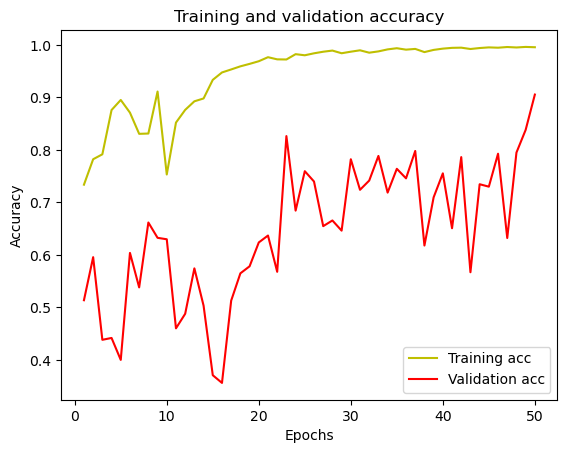

In [30]:
os.chdir(startdir)
path="./data/afdb/MinMax_ol1.0_win16/"

X = np.load(path+"X.npy",allow_pickle=True)
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)


#reshape data: 
# reshape input to be [samples, time steps, features = 1]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))

buildList=[ 
        [buildBase(),'Base'],
           ]

for build in buildList:
    os.chdir(startdir)
    model = build[0] 
    print('*****new model***')
    print('running model: '+build[1] )
        
    try:
        os.mkdir('./results/newmodels_fixed/'+build[1])
        print('made dir '+build[1])
    except OSError as error:
        print('dir already exists')
        pass                
       
    os.chdir('./results/newmodels_fixed/'+build[1]+'/')

    split_train_eval(model, 50, 128, True)

# Evaluate on other datasets

### - fixed length approach tuned base model
- 4000 samples segments
- MinMax pr segment
- overlap 0.1

N windows in total is 461726  

***indices of ***
(array([    90,     91,     92, ..., 461694, 461695, 461696]), array([0, 0, 0, ..., 0, 0, 0]))
N windows after removal is 311439  

***ids***
(311439,)
***X***
(311439, 4000, 1)
***Y***
(311439, 2)
***annot***
(311439,)
dir already exists
9733/9733 [==============================] - 836s 86ms/step
[[0.04573664 0.95383704]
 [0.24286658 0.7487963 ]
 [0.73643845 0.2571531 ]
 [0.9972756  0.00264615]
 [0.9981518  0.00177124]
 [0.98426324 0.01576641]
 [0.65652466 0.3322218 ]
 [0.07747513 0.9202997 ]
 [0.9914712  0.00816531]
 [0.99740887 0.00261634]]
using probability for having AFIB
[0.95383704 0.7487963  0.2571531  0.00264615 0.00177124 0.01576641
 0.3322218  0.9202997  0.00816531 0.00261634]
y_pred_cl
[1 1 0 0 0 0 0 1 0 0]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_test
[1 1 1 1 1 1 1 1 1 1]


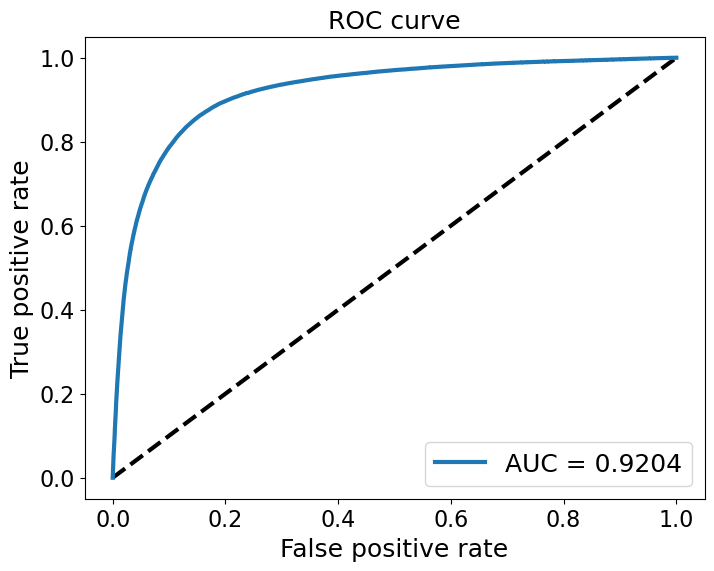

Confusion matrix, without normalization
[[145407  20412]
 [ 25528 120092]]


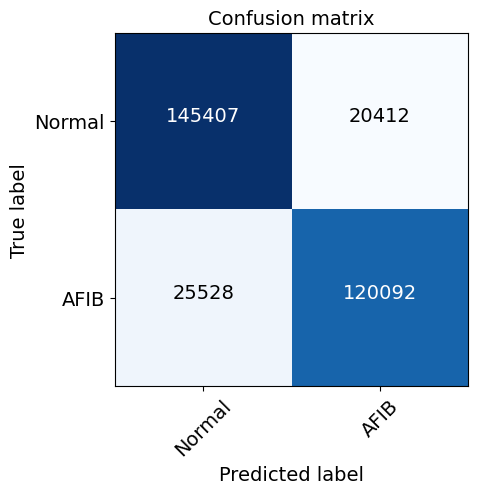

Normalized confusion matrix
[[87.69019232 12.30980768]
 [17.53055899 82.46944101]]


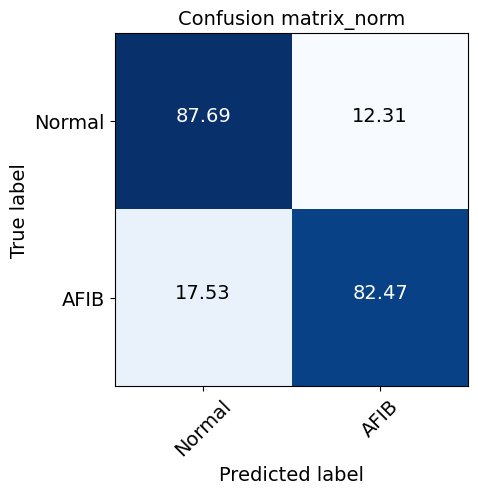

appended metrics


In [18]:
os.chdir(startdir)
timeToFit=999
model = pickle.load(open('./data/afdb/MinMax_ol1.0_win16/fullDataModel.pkl', 'rb'))

metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                        columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])


"""Read and evaluate datasets in loop"""
#datasets = ['mitdb', 'nsrdb', 'afdb','ltafdb']
datasets = ['ltafdb']


for testdata in datasets:


    testpath = "./data/"+testdata+"/MinMax_ol10_win16/"     
    X_test = np.load(testpath+"X.npy")
    y_test = np.load(testpath+"y.npy")
    ids_test = np.load(testpath+"ids.npy")
    annot = np.load(testpath+"annot_data.npy")
    
    #remove segments not AFIB or Normal
    print(f'N windows in total is {len(annot)}  \n')
    other = np.where( annot == 'Other')
    print('***indices of ***')
    print(np.where( annot == 'Other'))
    #print(other)
    annot = np.delete(annot, other)
    X_test = np.delete(X_test, other,0)
    y_test = np.delete(y_test, other,0)
    ids_test = np.delete(ids_test, other)
    print(f'N windows after removal is {len(annot)}  \n')  
    
    #confirm that arrays are same length and correct shape
    print('***ids***')
    print(np.shape(ids_test))
    print('***X***')
    print(np.shape(X_test))
    print('***Y***')
    print(np.shape(y_test))
    print('***annot***')
    print(np.shape(annot)) 
    
    #innerPath='results/logo/'+testID)
    innerPath='/results/'+testdata+'_fixed_basis'

    try:
        os.mkdir(startdir+innerPath)
        print('made dir '+testdata)
    except OSError as error:
        print('dir already exists')
        pass                

    os.chdir(startdir+innerPath)

    toappend = evaluate(X_test, y_test, model, testdata , timeToFit)
    toappend.to_pickle('metrics.pkl')
    metrics = pd.concat([metrics, toappend])
    print("appended metrics")
    os.chdir(startdir)
toappend.to_pickle('./results/allDatasetsFixBasis_metrics.pkl')


In [25]:
print(df['symbol'].value_counts())
df.groupby(['id', 'symbol']).size().reset_index().pivot(columns='symbol', index='id', values=0)


symbol
O    5325
N      88
A      36
Name: count, dtype: int64


symbol     A     N      O
id                       
100      NaN   NaN  113.0
101      NaN   NaN   93.0
102      NaN   NaN  109.0
103      NaN   NaN  104.0
104      NaN   NaN  110.0
105      NaN   NaN  128.0
106      NaN   NaN  101.0
107      NaN   NaN  106.0
108      NaN  88.0    NaN
109      NaN   NaN  126.0
111      NaN   NaN  106.0
112      NaN   NaN  126.0
113      NaN   NaN   89.0
114      NaN   NaN   93.0
115      NaN   NaN   97.0
116      NaN   NaN  120.0
117      NaN   NaN   76.0
118      NaN   NaN  113.0
119      NaN   NaN   99.0
121      NaN   NaN   93.0
122      NaN   NaN  123.0
123      NaN   NaN   75.0
124      NaN   NaN   80.0
200      NaN   NaN  130.0
201      NaN   NaN   98.0
202     16.0   NaN   90.0
203      NaN   NaN  148.0
205      NaN   NaN  132.0
207      NaN   NaN   93.0
208      NaN   NaN  147.0
209      NaN   NaN  150.0
210      NaN   NaN  132.0
212      NaN   NaN  137.0
213      NaN   NaN  162.0
214      NaN   NaN  113.0
215      NaN   NaN  168.0
217     16.0   NaN   94.0
219      NaN   NaN  107.0
220      NaN   NaN  102.0
221      NaN   NaN  121.0
222      4.0   NaN  120.0
223      NaN   NaN  130.0
228      NaN   NaN  102.0
230      NaN   NaN  112.0
231      NaN   NaN   78.0
232      NaN   NaN   89.0
233      NaN   NaN  153.0
234      NaN   NaN  137.0

In [ ]:

#innerPath='results/logo/'+testID)
innerPath='/results/'+testdata+'_fixed_basis'

try:
    os.mkdir(startdir+innerPath)
    print('made dir '+testdata)
except OSError as error:
    print('dir already exists')
    pass                

os.chdir(startdir+innerPath)

toappend = evaluate(X_test, y_test, model, testdata , timeToFit)
#toappend.to_pickle('metrics.pkl')
#metrics = pd.concat([metrics, toappend])
print("appended metrics")
os.chdir(startdir)
#toappend.to_pickle('./results/allDatasetsFixBasis_metrics.pkl')


In [11]:
print(np.shape(y_test))

(5001, 1)


In [7]:
#reshape data: 
# reshape input to be [samples, time steps, features = 1]
#X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#confirm that arrays are same length
print(np.shape(ids_test))   
print(np.shape(X_test))
print(np.shape(y_test))

(461674,)
(1846903948,)
(923400,)


### - fixed length approach alternative models
- 4000 samples segments
- MinMax pr segment
- overlap 0.1

N windows in total is 461726  

***indices of ***
(array([    90,     91,     92, ..., 461694, 461695, 461696]), array([0, 0, 0, ..., 0, 0, 0]))
N windows after removal is 311439  

***ids***
(311439,)
***X***
(311439, 4000, 1)
***Y***
(311439, 2)
***annot***
(311439,)
made dir ltafdb
9733/9733 [==============================] - 1120s 115ms/step
[[1.9258367e-01 8.0720460e-01]
 [3.6316197e-02 9.6377420e-01]
 [8.0829227e-01 1.9104677e-01]
 [9.2124742e-01 7.8342594e-02]
 [9.9936414e-01 6.3405535e-04]
 [9.3488365e-01 6.4311557e-02]
 [9.0286654e-01 9.7017206e-02]
 [1.8792053e-01 8.1185085e-01]
 [9.8560941e-01 1.4384161e-02]
 [8.7403494e-01 1.2545253e-01]]
using probability for having AFIB
[8.0720460e-01 9.6377420e-01 1.9104677e-01 7.8342594e-02 6.3405535e-04
 6.4311557e-02 9.7017206e-02 8.1185085e-01 1.4384161e-02 1.2545253e-01]
y_pred_cl
[1 1 0 0 0 0 0 1 0 0]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_test
[1 1 1 1 1 1 1 1 1 1]


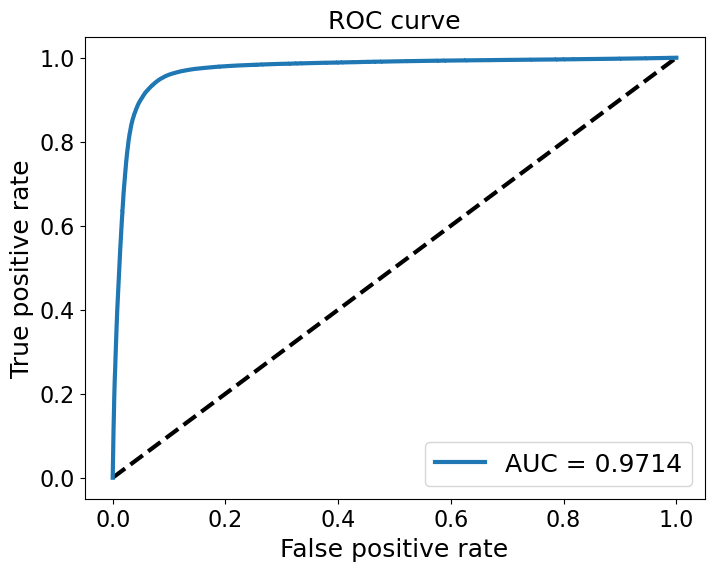

Confusion matrix, without normalization
[[155377  10442]
 [ 10990 134630]]


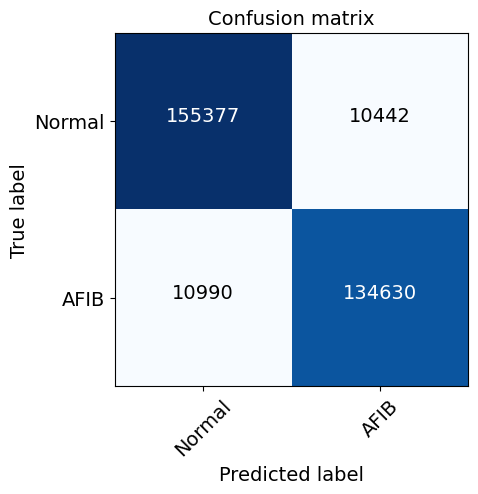

Normalized confusion matrix
[[93.7027723   6.2972277 ]
 [ 7.54704024 92.45295976]]


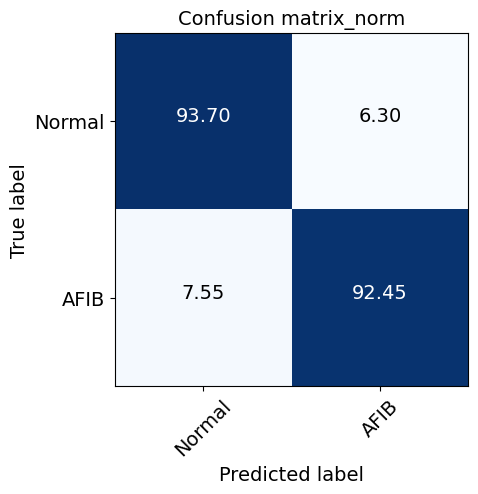

appended metrics
N windows in total is 461726  

***indices of ***
(array([    90,     91,     92, ..., 461694, 461695, 461696]), array([0, 0, 0, ..., 0, 0, 0]))
N windows after removal is 311439  

***ids***
(311439,)
***X***
(311439, 4000, 1)
***Y***
(311439, 2)
***annot***
(311439,)
made dir ltafdb
9733/9733 [==============================] - 913s 93ms/step
[[4.5019376e-01 5.3800857e-01]
 [7.8015321e-01 2.0705315e-01]
 [9.9674600e-01 3.2434480e-03]
 [7.3834330e-01 2.6157808e-01]
 [9.9699354e-01 3.1051433e-03]
 [9.2412889e-01 7.1321093e-02]
 [9.8065919e-01 1.9218158e-02]
 [3.9879939e-01 5.9438354e-01]
 [9.9374014e-01 6.0244673e-03]
 [9.9988645e-01 1.1652433e-04]]
using probability for having AFIB
[5.3800857e-01 2.0705315e-01 3.2434480e-03 2.6157808e-01 3.1051433e-03
 7.1321093e-02 1.9218158e-02 5.9438354e-01 6.0244673e-03 1.1652433e-04]
y_pred_cl
[1 0 0 0 0 0 0 1 0 0]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_test
[1 1 1 1 1 1 1 1 1 1]


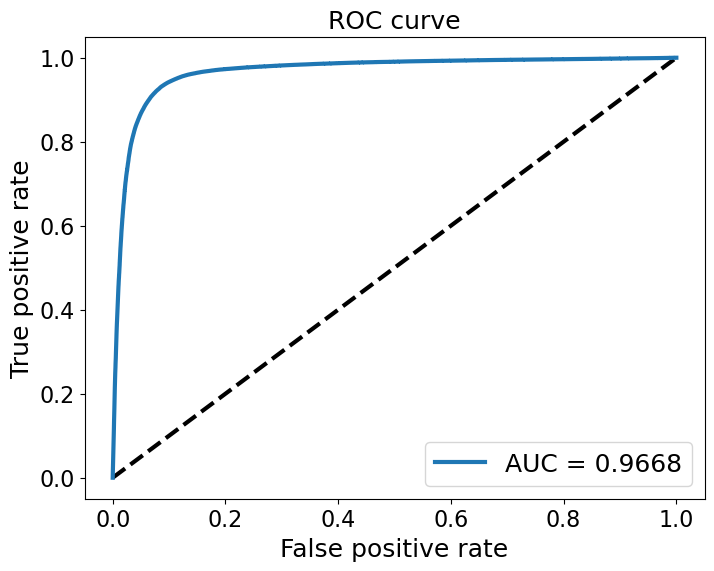

Confusion matrix, without normalization
[[156626   9193]
 [ 17270 128350]]


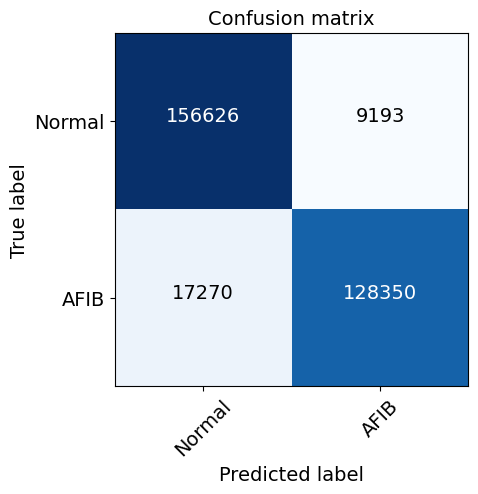

Normalized confusion matrix
[[94.45600323  5.54399677]
 [11.85963467 88.14036533]]


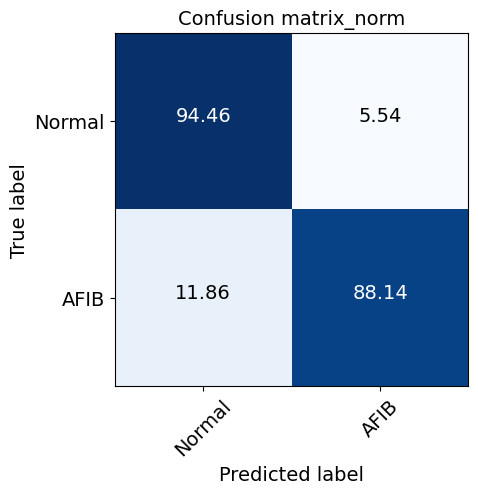

appended metrics
N windows in total is 461726  

***indices of ***
(array([    90,     91,     92, ..., 461694, 461695, 461696]), array([0, 0, 0, ..., 0, 0, 0]))
N windows after removal is 311439  

***ids***
(311439,)
***X***
(311439, 4000, 1)
***Y***
(311439, 2)
***annot***
(311439,)
made dir ltafdb
9733/9733 [==============================] - 814s 84ms/step
[[0.09089441 0.9105601 ]
 [0.00219223 0.9978722 ]
 [0.9213526  0.07776272]
 [0.9345879  0.06400774]
 [0.13538101 0.865048  ]
 [0.9664583  0.0343828 ]
 [0.95318806 0.04577936]
 [0.8790022  0.12468801]
 [0.994819   0.0050973 ]
 [0.9330382  0.06953255]]
using probability for having AFIB
[0.9105601  0.9978722  0.07776272 0.06400774 0.865048   0.0343828
 0.04577936 0.12468801 0.0050973  0.06953255]
y_pred_cl
[1 1 0 0 1 0 0 0 0 0]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_test
[1 1 1 1 1 1 1 1 1 1]


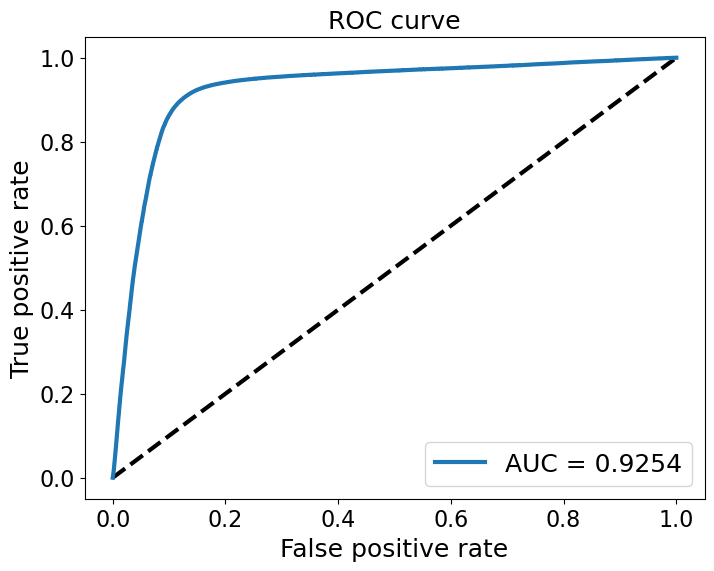

Confusion matrix, without normalization
[[145999  19820]
 [ 15035 130585]]


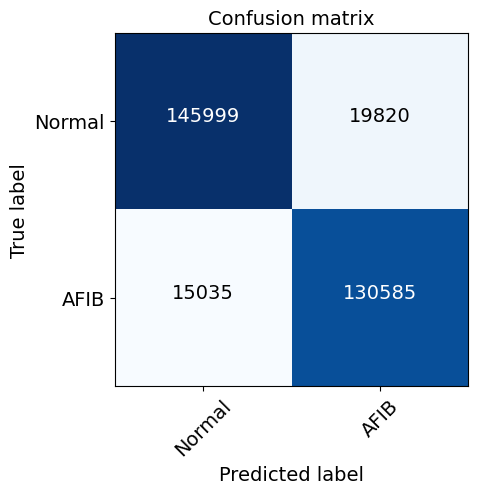

Normalized confusion matrix
[[88.0472081  11.9527919 ]
 [10.32481802 89.67518198]]


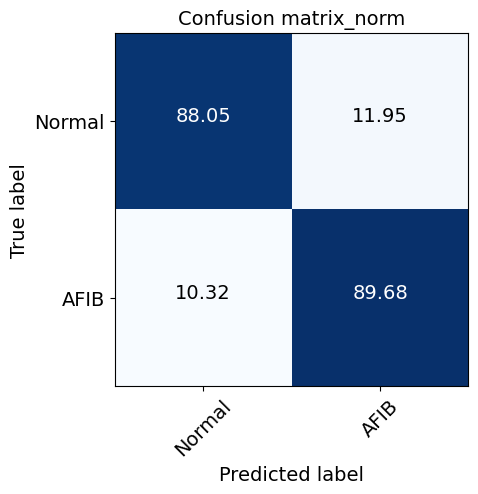

appended metrics


In [19]:
#ECG_masters/results/newmodels_fixed/bi_top_drop/trained_model.pkl
             
os.chdir(startdir)
timeToFit=999

modellist = ['bi_top_drop','filltop','base']

for name in modellist:

    model = pickle.load(open('./data/afdb/MinMax_ol1.0_win16/'+name+'fullDataModel.pkl', 'rb'))

    metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                            columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])


    """Read and evaluate datasets in loop"""
    datasets = ['ltafdb']
#'ltafdb'
    for testdata in datasets:

        testpath = "./data/"+testdata+"/MinMax_ol10_win16/"     
        X_test = np.load(testpath+"X.npy")
        y_test = np.load(testpath+"y.npy")
        ids_test = np.load(testpath+"ids.npy")
        annot = np.load(testpath+"annot_data.npy")
        
        #remove segments not AFIB or Normal
        print(f'N windows in total is {len(annot)}  \n')
        other = np.where( annot == 'Other')
        print('***indices of ***')
        print(np.where( annot == 'Other'))
        #print(other)
        annot = np.delete(annot, other)
        X_test = np.delete(X_test, other,0)
        y_test = np.delete(y_test, other,0)
        ids_test = np.delete(ids_test, other)
        print(f'N windows after removal is {len(annot)}  \n')  

        #confirm that arrays are same length and correct shape
        print('***ids***')
        print(np.shape(ids_test))
        print('***X***')
        print(np.shape(X_test))
        print('***Y***')
        print(np.shape(y_test))
        print('***annot***')
        print(np.shape(annot)) 

        #innerPath='results/logo/'+testID)
        innerPath='/results/'+testdata+'_fixed_'+name

        try:
            os.mkdir(startdir+innerPath)
            print('made dir '+testdata)
        except OSError as error:
            print('dir already exists')
            pass                

        os.chdir(startdir+innerPath)


        toappend = evaluate(X_test, y_test, model, testdata , timeToFit)
        toappend.to_pickle('metrics.pkl')
        metrics = pd.concat([metrics, toappend])
        print("appended metrics")
        os.chdir(startdir)
    toappend.to_pickle('./results/allDatasets_fixed'+name+'_metrics.pkl')


### pr Bt length approach
 10, 20 and 60 beats 
 

N windows in total is 899545  

***indices of ***
(array([   246,    247,    248, ..., 899502, 899503, 899504]),)
N windows after removal is 617090  

***ids***
(617090,)
***X***
(617090, 1955, 1)
***Y***
(617090, 2)
***annot***
(617090,)
made dir ltafdb
19285/19285 [==============================] - 945s 49ms/step
[[0.29719526 0.7020112 ]
 [0.00623232 0.9936899 ]
 [0.2611005  0.73764086]
 [0.6252292  0.37176725]
 [0.77133095 0.22724915]
 [0.91814524 0.08076613]
 [0.55729437 0.439388  ]
 [0.9907648  0.00912382]
 [0.9226363  0.07709318]
 [0.00702184 0.99290776]]
using probability for having AFIB
[0.7020112  0.9936899  0.73764086 0.37176725 0.22724915 0.08076613
 0.439388   0.00912382 0.07709318 0.99290776]
y_pred_cl
[1 1 1 0 0 0 0 0 0 1]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_test
[1 1 1 1 1 1 1 1 1 1]


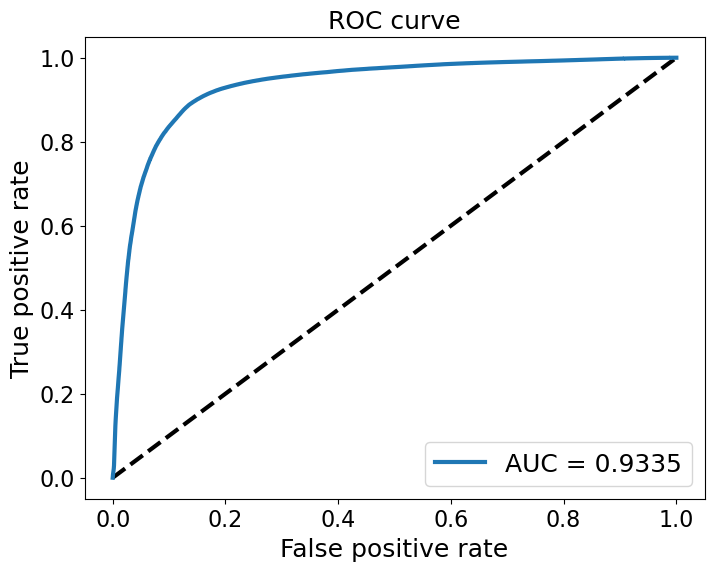

Confusion matrix, without normalization
[[261168  28634]
 [ 54244 273044]]


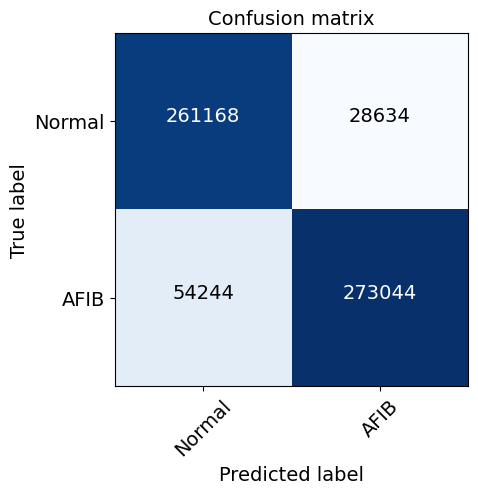

Normalized confusion matrix
[[90.11946087  9.88053913]
 [16.57378211 83.42621789]]


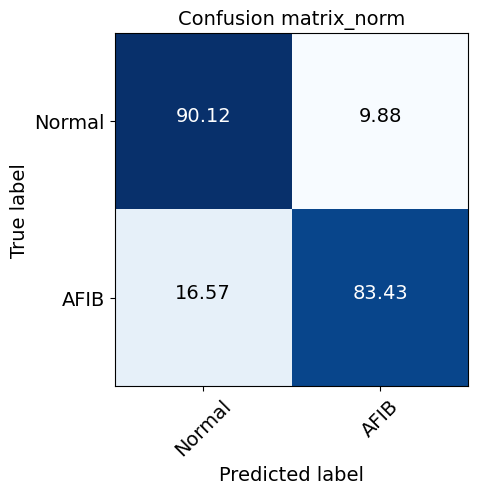

appended metrics
N windows in total is 449749  

***indices of ***
(array([   123,    124,    125, ..., 449727, 449728, 449729]),)
N windows after removal is 310161  

***ids***
(310161,)
***X***
(310161, 4131, 1)
***Y***
(310161, 2)
***annot***
(310161,)
made dir ltafdb
9693/9693 [==============================] - 867s 89ms/step
[[0.7269405  0.25204584]
 [0.4917455  0.482382  ]
 [0.3068731  0.67157423]
 [0.3429449  0.6340715 ]
 [0.08301095 0.9097623 ]
 [0.16585873 0.82051367]
 [0.3824223  0.59334564]
 [0.23989706 0.7419805 ]
 [0.50941604 0.46458143]
 [0.2909867  0.6881392 ]]
using probability for having AFIB
[0.25204584 0.482382   0.67157423 0.6340715  0.9097623  0.82051367
 0.59334564 0.7419805  0.46458143 0.6881392 ]
y_pred_cl
[0 0 1 1 1 1 1 1 0 1]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
y_test
[1 1 1 1 1 1 1 1 1 1]


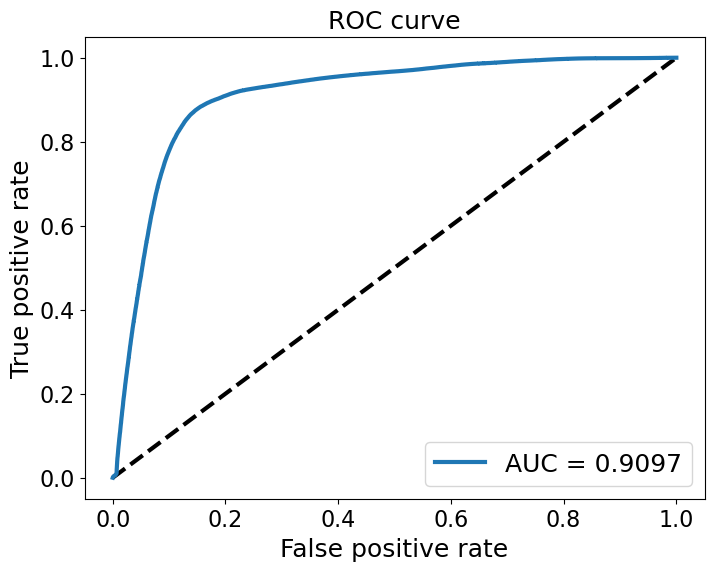

Confusion matrix, without normalization
[[122622  23859]
 [ 18336 145344]]


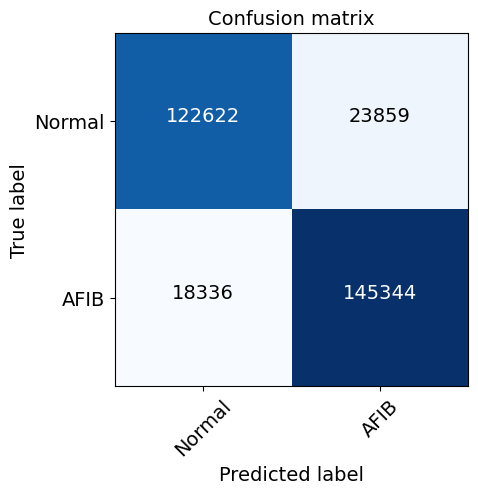

Normalized confusion matrix
[[83.71188072 16.28811928]
 [11.20234604 88.79765396]]


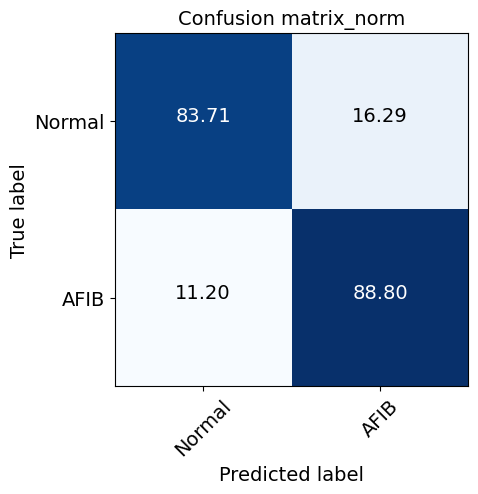

appended metrics
N windows in total is 149885  

***indices of ***
(array([    41,     42,     43, ..., 149874, 149875, 149878]),)
N windows after removal is 103782  

***ids***
(103782,)
***X***
(103782, 11202, 1)
***Y***
(103782, 2)
***annot***
(103782,)
made dir ltafdb
 358/3244 [==>...........................] - ETA: 11:32

In [ ]:
import tensorflow as tf
os.chdir(startdir)
timeToFit=999

modellist = [['10_trunc75',1955],['20_trunc75',4131],['60_trunc60',11202]]
#modellist = [['60_trunc60',11202]]


for name in modellist:

    model = pickle.load(open('./data/afdb/prBt'+name[0]+'/fullDataModel.pkl', 'rb'))

    metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                            columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])


    """Read and evaluate datasets in loop"""
    #datasets = ['nsrdb','mitdb' ]
    datasets = ['ltafdb']

    for testdata in datasets:

        testpath = "./data/"+testdata+"/prBt"+name[0]+"_MinMax_win/"     
        X_test = np.load(testpath+"X.npy")
        #adjust segment length in accordance with AFDB training
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=-2,
                                                          dtype='float64',
                                                          padding='post',
                                                          maxlen=name[1])

        y_test = np.load(testpath+"y.npy")
        ids_test = np.load(testpath+"ids.npy")
        annot = np.load(testpath+"annot_data.npy")
        
        
        #remove segments not AFIB or Normal
        print(f'N windows in total is {len(annot)}  \n')
        other = np.where( annot == 'Other')
        print('***indices of ***')
        print(np.where( annot == 'Other'))
        #print(other)
        annot = np.delete(annot, other)
        X_test = np.delete(X_test, other,0)
        y_test = np.delete(y_test, other,0)
        ids_test = np.delete(ids_test, other)
        print(f'N windows after removal is {len(annot)}  \n')  

        #confirm that arrays are same length and correct shape
        print('***ids***')
        print(np.shape(ids_test))
        print('***X***')
        print(np.shape(X_test))
        print('***Y***')
        print(np.shape(y_test))
        print('***annot***')
        print(np.shape(annot)) 


        #innerPath='results/logo/'+testID)
        innerPath='/results/'+testdata+'_prbeat_'+name[0]

        try:
            os.mkdir(startdir+innerPath)
            print('made dir '+testdata)
        except OSError as error:
            print('dir already exists')
            pass                

        os.chdir(startdir+innerPath)


        toappend = evaluate(X_test, y_test, model, testdata , timeToFit)
        toappend.to_pickle('metrics.pkl')
        metrics = pd.concat([metrics, toappend])
        print("appended metrics")
        os.chdir(startdir)
    toappend.to_pickle('./results/allDatasets_prBt'+name[0]+'_metrics.pkl')



# Train on entire datasets

In [12]:
#train and save function

def train_save(MODEL,X_TRAIN,y_TRAIN, modelname,  epochsN=50,BATCH=128):
    
    MODEL.compile(loss='binary_crossentropy',
        optimizer='adam', metrics = ['accuracy'])

    MODEL.fit(X_TRAIN, y_TRAIN,    
                    epochs=epochsN,
                    batch_size = BATCH,
                    #validation_data=(X_test, y_test),
                    shuffle=True,        
                    verbose=1)
    print("fitted")
    #save trained model
    pickle.dump(MODEL, open(modelname+'fullDataModel.pkl', 'wb'))

### AFDB pr number beats

In [6]:
datasets= ['60_trunc60_overlap0']
#'10_trunc75','20_trunc75',

for name in datasets:

    os.chdir(startdir+'/data/afdb/prBt'+name)
    X = np.load("X.npy",allow_pickle=True)
    #X = ak.from_parquet("X.parquet")
    y = np.load("y.npy",allow_pickle=True)
    ids = np.load("ids.npy",allow_pickle=True)

    model = build_mask()
    train_save(model,X,y, epochsN=50,BATCH=128)


Model: "combo_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 11202, 1)]        0         
                                                                 
 Masking1 (Masking)          (None, 11202, 1)          0         
                                                                 
 conv1 (Conv1D)              (None, 11200, 32)         128       
                                                                 
 batch1 (BatchNormalization)  (None, 11200, 32)        128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 5600, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 5598, 64)          6208      
                                                                 
 batch2 (BatchNormalization)  (None, 5598, 64)         2

### AFDB segment 4000, overlap 0.1, MinMax pr segment

In [13]:
os.chdir(startdir+'/data/afdb/MinMax_ol1.0_win16')
X = np.load("X.npy",allow_pickle=True)
#X = ak.from_parquet("X.parquet")
y = np.load("y.npy",allow_pickle=True)
ids = np.load("ids.npy",allow_pickle=True)
annot = np.load("annot_data.npy",allow_pickle=True)


print(f'N windows in total is {len(annot)}  \n')
other = np.where( annot == 'Other')
print('***indices of ***')
print(np.where( annot == 'Other'))
#print(other)
annot = np.delete(annot, other)
X = np.delete(X, other,0)
y = np.delete(y, other,0)
ids = np.delete(ids, other)
print(f'N windows after removal is {len(annot)}  \n')  

#confirm that arrays are same length and correct shape
print('***ids***')
print(np.shape(ids))
print('***X***')
print(np.shape(X))
print('***Y***')
print(np.shape(y))
print('***annot***')
print(np.shape(annot)) 

"""
model = buildBest_2()
train_save(model,X,y, 'basetuned', epochsN=50,BATCH=32)
"""

model = buildBase()
train_save(model,X,y,'base', epochsN=50,BATCH=128)

model = build_explore_fixed(2, denseLayers=1, typeLSTM='1 LSTM', dropout=False)
train_save(model,X,y,'filltop', epochsN=50,BATCH=32)

model = build_explore_fixed(top=2, denseLayers=1, typeLSTM='1 biLSTM', dropout=True)
train_save(model,X,y,'bi_top_drop', epochsN=50,BATCH=32)
           


N windows in total is 55357  

***indices of ***
(array([], dtype=int64),)
N windows after removal is 55357  

***ids***
(55357,)
***X***
(55357, 4000, 1)
***Y***
(55357, 2)
***annot***
(55357,)
Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 4000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 3996, 32)          192       
                                                                 
 batch1 (BatchNormalization)  (None, 3996, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1998, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1994, 64)          10304     
                                                                

# LOGO

## pr Beat number 

### prBt10 w MinMax pr window truncated at 75th 

In [ ]:
print(os.getcwd())

#os.chdir(startdir)

path="./data/afdb/prBt10_trunc75/"
X = np.load(path+"X.npy",allow_pickle=True)
#X = ak.from_parquet("X.parquet")
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

# exclude id=22

index22 = np.where( ids == '08434')
print(index22)
newX = np.delete(X, index22,0)
newy = np.delete(y, index22,0)
newids = np.delete(ids, index22)

print(np.shape(newids))   
print(np.shape(newX))
print(np.shape(newy))

X = newX
y = newy
ids = newids

logoloopMask('/results/logomask_prBt10/',build_mask_best_drop )

### prBt60 w MinMax pr window truncated at 60th 

In [ ]:
print(os.getcwd())

#os.chdir(startdir)

path="./data/afdb/prBt60_trunc60_overlap0/"
X = np.load(path+"X.npy",allow_pickle=True)
#X = ak.from_parquet("X.parquet")
y = np.load(path+"y.npy",allow_pickle=True)
ids = np.load(path+"ids.npy",allow_pickle=True)

# exclude id=22

index22 = np.where( ids == '08434')
print(index22)
newX = np.delete(X, index22,0)
newy = np.delete(y, index22,0)
newids = np.delete(ids, index22)

print(np.shape(newids))   
print(np.shape(newX))
print(np.shape(newy))

X = newX
y = newy
ids = newids

logoloopMask('/results/logomask_prBt60/',build_mask_best_drop )